# Analysis pipeline_4U_DMS

## This code is to generate interactive MA plots for Rif DMS samples. 

Coded by Yumeng Hao

### Load packages for downstream analysis

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

# Bokeh libraries
from bokeh.io import output_file, output_notebook, export_png, show
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, LabelSet, HoverTool, Toggle, BoxAnnotation, CustomJS, Band
from bokeh.layouts import row, column, gridplot, layout
from bokeh.models.widgets import Tabs, Panel, CheckboxGroup
import math

### Load mutation rates for samples, all nt

In [2]:
#Load dataset, this time I use 1st Rif dataset raw values with only 16S as a test dataset
#Can also load the processed AC data as a set and select cert

df = pd.read_csv("/Users/yhao12/Desktop/Rif_jupyter/DMS_csv/2ndRif_all_fullseq.csv")
RNA_types = df[df.columns[0]].unique()

pd.set_option('display.max_rows', 60)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
RNA_types = df[df.columns[0]].unique()

In [4]:
df.head()

,rRNA,position,nucleotide,4sU_10m_ND,Rif_0m_ND,Rif_6m_ND,Rif_10m_ND,4sU_10m_DMS1,4sU_10m_DMS2,Rif_0m_DMS,Rif_30s_DMS,Rif_1m_DMS,Rif_2m_DMS,Rif_3m_DMS,Rif_5m_DMS,Rif_10m_DMS,ND_ctrl,DMS_ctrl
0,E.c.16S_rRNA,1,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E.c.16S_rRNA,2,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E.c.16S_rRNA,3,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E.c.16S_rRNA,4,T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,E.c.16S_rRNA,5,G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.shape

(5819, 18)

### Process the data to different rRNA with leader and trailer, also RNase P and tmRNA

In [6]:
df.rRNA.loc[(df.rRNA == 'E.c.23S__rRNA') & (df.position > 3119)] = 'E.c.5S___rRNA'
df.position.loc[(df.rRNA == 'E.c.5S___rRNA')] -= 3119
df.rRNA.loc[(df.rRNA == 'E.c.5S___rRNA') & (df.position >120)] = 'E.c.5S___rRNA_trailer'

df.position.loc[(df.rRNA == 'E.c.16S_rRNA') & (df.position <= 147)] -= 148
df.rRNA.loc[(df.rRNA == 'E.c.16S_rRNA') & (df.position < 0)] = 'E.c.16S_rRNA_leader'
df.position.loc[(df.rRNA == 'E.c.16S_rRNA') & (df.position >= 148)] -= 147
df.rRNA.loc[(df.rRNA == 'E.c.16S_rRNA') & (df.position > 1542)] = 'E.c.16S_rRNA_trailer'

df.position.loc[(df.rRNA == 'E.c.23S__rRNA') & (df.position <= 122)] -= 123
df.rRNA.loc[(df.rRNA == 'E.c.23S__rRNA') & (df.position < 0)] = 'E.c.23S__rRNA_leader'
df.position.loc[(df.rRNA == 'E.c.23S__rRNA') & (df.position >= 123)] -= 122
df.rRNA.loc[(df.rRNA == 'E.c.23S__rRNA') & (df.position > 2904)] = 'E.c.23S__rRNA_trailer'

#df.position.loc[(df.rRNA == 'E.c.SRP')] += 119

In [7]:
#df.to_csv('2ndRif_allseq_processed.csv')

### Calculate averages for controls

In [8]:
#Calculate average for Rif_ND controls 

ND_avg= df.iloc[:, 3:7].mean(axis=1)
df.insert(18, 'Rif_NDs_mean',ND_avg)

In [9]:
#Calculate average for 4sU_DMS samples
DMS_4sU_avg = df.iloc[:, 7:9].mean(axis=1)
df.insert(19, 'DMS_4sU_ctrl_mean',DMS_4sU_avg)

### Calculate ratio and averages for samples

In [10]:
#Only select the ones we like to analyze

df_sample_log= df.loc[:,['rRNA','position','nucleotide','ND_ctrl','DMS_ctrl','Rif_0m_DMS','Rif_30s_DMS','Rif_1m_DMS','Rif_2m_DMS',
              'Rif_3m_DMS','Rif_5m_DMS','Rif_10m_DMS','Rif_NDs_mean','DMS_4sU_ctrl_mean']]

In [11]:
#calculate the mutation ratios(samples/DMS_ctrl), log2
df_sample_log['ratio_0m_log'] = np.log2(df_sample_log['Rif_0m_DMS'])-np.log2(df_sample_log['DMS_ctrl'])
df_sample_log['ratio_30s_log'] = np.log2(df_sample_log['Rif_30s_DMS'])-np.log2(df_sample_log['DMS_ctrl'])
df_sample_log['ratio_1m_log'] = np.log2(df_sample_log['Rif_1m_DMS'])-np.log2(df_sample_log['DMS_ctrl'])
df_sample_log['ratio_2m_log'] = np.log2(df_sample_log['Rif_2m_DMS'])-np.log2(df_sample_log['DMS_ctrl'])
df_sample_log['ratio_3m_log'] = np.log2(df_sample_log['Rif_3m_DMS'])-np.log2(df_sample_log['DMS_ctrl'])
df_sample_log['ratio_5m_log'] = np.log2(df_sample_log['Rif_5m_DMS'])-np.log2(df_sample_log['DMS_ctrl'])
df_sample_log['ratio_10m_log'] = np.log2(df_sample_log['Rif_10m_DMS'])-np.log2(df_sample_log['DMS_ctrl'])
df_sample_log['ratio_ctrl_log'] = np.log2(df_sample_log['DMS_4sU_ctrl_mean'])-np.log2(df_sample_log['DMS_ctrl'])

#calculate log2 of mutation rates
#df_sample_log['average_0m_log'] = (np.log2(df_sample_log['Rif_0m_DMS']*100) + np.log2(df_sample_log['DMS_ctrl']*100))/2
#df_sample_log['average_30s_log'] = (np.log2(df_sample_log['Rif_30s_DMS']*100) + np.log2(df_sample_log['DMS_ctrl']*100))/2
#df_sample_log['average_1m_log'] = (np.log2(df_sample_log['Rif_1m_DMS']*100) + np.log2(df_sample_log['DMS_ctrl']*100))/2
#df_sample_log['average_2m_log'] = (np.log2(df_sample_log['Rif_2m_DMS']*100) + np.log2(df_sample_log['DMS_ctrl']*100))/2
#df_sample_log['average_3m_log'] = (np.log2(df_sample_log['Rif_3m_DMS']*100) + np.log2(df_sample_log['DMS_ctrl']*100))/2
#df_sample_log['average_5m_log'] = (np.log2(df_sample_log['Rif_5m_DMS']*100) + np.log2(df_sample_log['DMS_ctrl']*100))/2
#df_sample_log['average_10m_log'] = (np.log2(df_sample_log['Rif_10m_DMS']*100) + np.log2(df_sample_log['DMS_ctrl']*100))/2
#df_sample_log['average_ctrl_log'] = (np.log2(df_sample_log['DMS_4sU_ctrl_mean']*100) + np.log2(df_sample_log['DMS_ctrl']*100))/2

#calculate the average mutation rates (sample, DMS_ctrl), log2
df_sample_log['average_0m_log'] = np.log2((df_sample_log['Rif_0m_DMS']*100+ df_sample_log['DMS_ctrl']*100)/2)
df_sample_log['average_30s_log'] = np.log2((df_sample_log['Rif_30s_DMS']*100+ df_sample_log['DMS_ctrl']*100)/2)
df_sample_log['average_1m_log'] = np.log2((df_sample_log['Rif_1m_DMS']*100+ df_sample_log['DMS_ctrl']*100)/2)
df_sample_log['average_2m_log'] = np.log2((df_sample_log['Rif_2m_DMS']*100+ df_sample_log['DMS_ctrl']*100)/2)
df_sample_log['average_3m_log'] = np.log2((df_sample_log['Rif_3m_DMS']*100+ df_sample_log['DMS_ctrl']*100)/2)
df_sample_log['average_5m_log'] = np.log2((df_sample_log['Rif_5m_DMS']*100+ df_sample_log['DMS_ctrl']*100)/2)
df_sample_log['average_10m_log'] = np.log2((df_sample_log['Rif_10m_DMS']*100+ df_sample_log['DMS_ctrl']*100)/2)
df_sample_log['average_ctrl_log'] = np.log2((df_sample_log['DMS_4sU_ctrl_mean']*100+ df_sample_log['DMS_ctrl']*100)/2)

#df_sample_log.to_csv('2ndRif_allnt_ratio_average_log2.csv')

/Users/yhao12/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/Users/yhao12/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
/Users/yhao12/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log2
/Users/yhao12/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log2
/Users/yhao12/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log2
/Users/yhao12/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log2
/Users/yhao12/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log2
/Users/yhao12/anaconda2/lib/python2

In [12]:
#Only select the ones we like to analyze

df_sample= df.loc[:,['rRNA','position','nucleotide','ND_ctrl','DMS_ctrl','Rif_0m_DMS','Rif_30s_DMS','Rif_1m_DMS','Rif_2m_DMS',
              'Rif_3m_DMS','Rif_5m_DMS','Rif_10m_DMS','Rif_NDs_mean','DMS_4sU_ctrl_mean']]

In [13]:
#calculate the mutation ratios of samples
df_sample['ratio_0m'] = df_sample['Rif_0m_DMS']/df_sample['DMS_ctrl']
df_sample['ratio_30s'] = df_sample['Rif_30s_DMS']/df_sample['DMS_ctrl']
df_sample['ratio_1m'] = df_sample['Rif_1m_DMS']/df_sample['DMS_ctrl']
df_sample['ratio_2m'] = df_sample['Rif_2m_DMS']/df_sample['DMS_ctrl']
df_sample['ratio_3m'] = df_sample['Rif_3m_DMS']/df_sample['DMS_ctrl']
df_sample['ratio_5m'] = df_sample['Rif_5m_DMS']/df_sample['DMS_ctrl']
df_sample['ratio_10m'] = df_sample['Rif_10m_DMS']/df_sample['DMS_ctrl']
df_sample['ratio_ctrl'] = df_sample['DMS_4sU_ctrl_mean']/df_sample['DMS_ctrl']

df_sample['average_0m'] =  (df_sample['Rif_0m_DMS']*100+ df_sample['DMS_ctrl']*100)/2
df_sample['average_30s'] =  (df_sample['Rif_30s_DMS']*100+ df_sample['DMS_ctrl']*100)/2
df_sample['average_1m'] =  (df_sample['Rif_1m_DMS']*100+ df_sample['DMS_ctrl']*100)/2
df_sample['average_2m'] =  (df_sample['Rif_2m_DMS']*100+ df_sample['DMS_ctrl']*100)/2
df_sample['average_3m'] =  (df_sample['Rif_3m_DMS']*100+ df_sample['DMS_ctrl']*100)/2
df_sample['average_5m'] =  (df_sample['Rif_5m_DMS']*100+ df_sample['DMS_ctrl']*100)/2
df_sample['average_10m'] =  (df_sample['Rif_10m_DMS']*100+ df_sample['DMS_ctrl']*100)/2
df_sample['average_ctrl'] =  (df_sample['DMS_4sU_ctrl_mean']*100+ df_sample['DMS_ctrl']*100)/2

#df_sample.to_csv('2ndRif_allnt_ratio_average.csv')


### Select A, C nucleotides from the sample

In [14]:
#Select rRNAs with trailer and leader

df_sample = df_sample[df_sample.rRNA != 'E.c.RNase_P']
df_sample = df_sample[df_sample.rRNA != 'E.c.SRP']
df_sample = df_sample[df_sample.rRNA != 'E.c.tmRNA']

df_sample.tail()

,rRNA,position,nucleotide,ND_ctrl,DMS_ctrl,Rif_0m_DMS,Rif_30s_DMS,Rif_1m_DMS,Rif_2m_DMS,Rif_3m_DMS,...,ratio_10m,ratio_ctrl,average_0m,average_30s,average_1m,average_2m,average_3m,average_5m,average_10m,average_ctrl
4977,E.c.5S___rRNA_trailer,126,T,0.210526,0.090909,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,4.545455,4.545455,4.545455,4.545455,4.545455,4.545455,4.545455,4.545455
4978,E.c.5S___rRNA_trailer,127,A,0.210526,0.090909,0.0,0.333333,0.0,0.0,0.0,...,0.0,0.0,4.545455,21.212121,4.545455,4.545455,4.545455,4.545455,4.545455,4.545455
4979,E.c.5S___rRNA_trailer,128,A,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4980,E.c.5S___rRNA_trailer,129,G,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4981,E.c.5S___rRNA_trailer,130,C,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
df_ACG = df_sample[df_sample.nucleotide != 'T']
df_AC = df_ACG[df_ACG.nucleotide != 'G']

In [16]:
#calculate the mutation ratios of samples
df_AC['ratio_0m'] = df_AC['Rif_0m_DMS']/df_AC['DMS_ctrl']
df_AC['ratio_30s'] = df_AC['Rif_30s_DMS']/df_AC['DMS_ctrl']
df_AC['ratio_1m'] = df_AC['Rif_1m_DMS']/df_AC['DMS_ctrl']
df_AC['ratio_2m'] = df_AC['Rif_2m_DMS']/df_AC['DMS_ctrl']
df_AC['ratio_3m'] = df_AC['Rif_3m_DMS']/df_AC['DMS_ctrl']
df_AC['ratio_5m'] = df_AC['Rif_5m_DMS']/df_AC['DMS_ctrl']
df_AC['ratio_10m'] = df_AC['Rif_10m_DMS']/df_AC['DMS_ctrl']
df_AC['ratio_ctrl'] = df_AC['DMS_4sU_ctrl_mean']/df_AC['DMS_ctrl']

df_AC['average_0m'] =  (df_AC['Rif_0m_DMS']*100+ df_AC['DMS_ctrl']*100)/2
df_AC['average_30s'] =  (df_AC['Rif_30s_DMS']*100+ df_AC['DMS_ctrl']*100)/2
df_AC['average_1m'] =  (df_AC['Rif_1m_DMS']*100+ df_AC['DMS_ctrl']*100)/2
df_AC['average_2m'] =  (df_AC['Rif_2m_DMS']*100+ df_AC['DMS_ctrl']*100)/2
df_AC['average_3m'] =  (df_AC['Rif_3m_DMS']*100+ df_AC['DMS_ctrl']*100)/2
df_AC['average_5m'] =  (df_AC['Rif_5m_DMS']*100+ df_AC['DMS_ctrl']*100)/2
df_AC['average_10m'] =  (df_AC['Rif_10m_DMS']*100+ df_AC['DMS_ctrl']*100)/2
df_AC['average_ctrl'] =  (df_AC['DMS_4sU_ctrl_mean']*100+ df_AC['DMS_ctrl']*100)/2

#df_AC.to_csv('2ndRif_AC_ratio_average.csv')

In [31]:
#df_AC.to_csv('2ndRif_rRNA_allAC_ratio_average.csv')

In [17]:
df_U = df_sample[df_sample.nucleotide == 'T']
df_U.head()

,rRNA,position,nucleotide,ND_ctrl,DMS_ctrl,Rif_0m_DMS,Rif_30s_DMS,Rif_1m_DMS,Rif_2m_DMS,Rif_3m_DMS,...,ratio_10m,ratio_ctrl,average_0m,average_30s,average_1m,average_2m,average_3m,average_5m,average_10m,average_ctrl
3,E.c.16S_rRNA_leader,-144,T,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,E.c.16S_rRNA_leader,-141,T,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,E.c.16S_rRNA_leader,-139,T,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,E.c.16S_rRNA_leader,-138,T,0.0,0.010753,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.537634,0.537634,0.537634,0.537634,0.537634,0.537634,0.537634,0.537634
10,E.c.16S_rRNA_leader,-137,T,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Line plot

In [17]:
df_sample['ND']= (df_sample.ND_ctrl)*100
df_sample['DMS']=(df_sample.DMS_ctrl)*100

In [18]:
df_16S_nt = df_sample.iloc[0:1733,:]
df_23S_nt = df_sample.iloc[1733:4852]

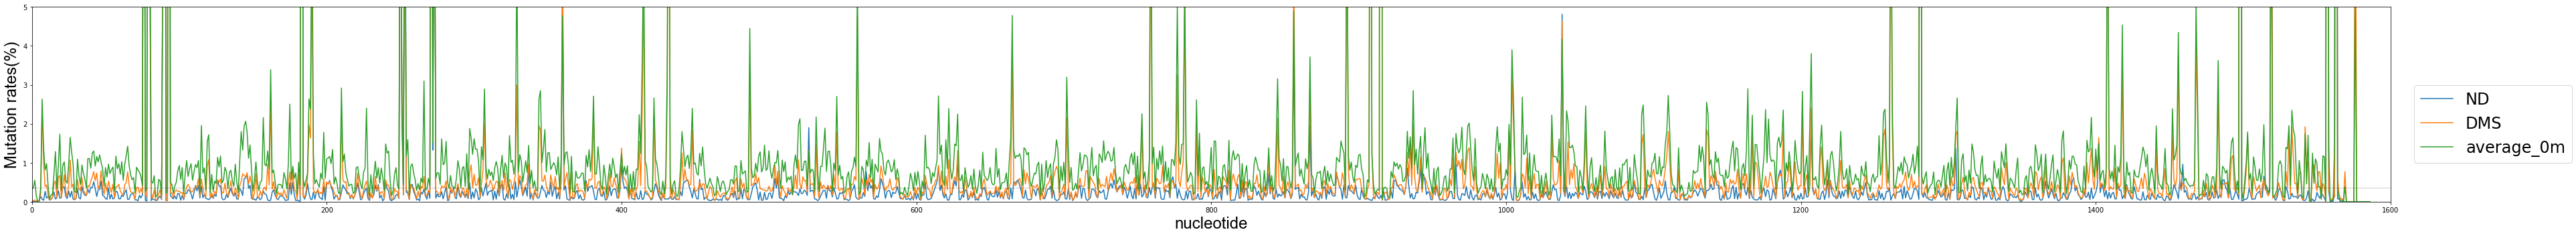

In [19]:
samples= ['ND','DMS','average_0m']

fig, ax = plt.subplots(figsize=(50, 5))
ax.set_xlabel('nucleotide', fontsize=24,fontname='Arial')
ax.set_ylabel('Mutation rates(%)', fontsize=24,fontname='Arial')
for sample in samples:
    plt.plot('position',sample, data=df_16S_nt,label=sample)
plt.axhline(0.35, color='black',linestyle=':' , linewidth=0.5)
#plt.axvline(-115, color='blue',linestyle=':' , linewidth=1)
#plt.axvline(-66, color='magenta',linestyle=':' , linewidth=1)
#plt.axvline(1690, color='grey',linestyle=':' , linewidth=0.5)
plt.xlim(0,1600)
plt.ylim(0,5)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.01,0.4), loc="center left", borderaxespad=0, fontsize=24)
#plt.savefig('2ndRif_0m_lineplot.pdf', orientation = 'landscape',bbox_inches = 'tight',pad_inches = 0.1, dpi=600)
plt.show() 



#'average_30s','average_1m','average_2m','average_3m','average_5m','average_10m'





### Select nucleotides with more variations from DMS_ctrl

In [20]:
pd.set_option('use_inf_as_na', True)
df.dropna(inplace=True)

In [25]:
#calculate the average and quantile for the data, decide what criteria to apply for data selection

ratio_mean=df_sample['ratio_0m'].mean(axis=0)
print ("Rif0m_ratio_mean:", ratio_mean)

ratio_median=df_sample['ratio_0m'].median(axis=0)
print ("Rif0m_ratio_median:", ratio_median)

avg_values_mean=df_sample['average_0m'].mean(axis=0)
print ("Rif0m_avg_median:", avg_values_mean)

print ("Rif0m_ratio_75%:",df_sample['ratio_0m'].quantile(0.75))
print ("Rif0m_ratio_50%:", df_sample['ratio_0m'].quantile(0.5))
print ("Rif0m_ratio_25%:",df_sample['ratio_0m'].quantile(0.25))

print ("Rif0m_avg%_90%:",df_sample['average_0m'].quantile(0.9))
print ("Rif0m_avg%_75%:",df_sample['average_0m'].quantile(0.75))
print ("Rif0m_avg%_50%:",df_sample['average_0m'].quantile(0.5))
print ("Rif0m_avg%_25%:",df_sample['average_0m'].quantile(0.25))
print ("Rif0m_avg%_10%:",df_sample['average_0m'].quantile(0.1))

print ("ND_median:", (df_sample['ND_ctrl']*100).median(axis=0))
print ("DMS_median:", (df_sample['DMS_ctrl']*100).median(axis=0))

#print df_sample_ratio_1.quantile(0.87)
#print df_sample_ratio_1.quantile(0.05)



('Rif0m_ratio_mean:', 3.621580062066891)
('Rif0m_ratio_median:', 3.1677568592354017)
('Rif0m_avg_median:', 1.1333594718988333)
('Rif0m_ratio_75%:', 4.419148919088568)
('Rif0m_ratio_50%:', 3.1622391635209617)
('Rif0m_ratio_25%:', 2.2263504773972653)
('Rif0m_avg%_90%:', 1.6983674400000017)
('Rif0m_avg%_75%:', 1.1088140874999999)
('Rif0m_avg%_50%:', 0.75398125)
('Rif0m_avg%_25%:', 0.41200525)
('Rif0m_avg%_10%:', 0.22331743499999998)
('ND_median:', 0.1523386)
('DMS_median:', 0.3494567)


In [36]:
#calculate the average and quantile for the data, decide what criteria to apply for data selection

ratio_mean_AC=df_AC['ratio_1m'].mean(axis=0)
print ("Rif1m_AC_ratio_mean:", ratio_mean_AC)

ratio_median_AC=df_AC['ratio_1m'].median(axis=0)
print ("Rif1m_AC_ratio_median:", ratio_median_AC)

avg_values_mean_AC=df_AC['average_1m'].mean(axis=0)
print ("Rif1m_AC_avg_median:", avg_values_mean_AC)

print ("Rif1m_AC_ratio_75%:",df_AC['ratio_1m'].quantile(0.75))
print ("Rif1m_AC_ratio_50%:", df_AC['ratio_1m'].quantile(0.5))
print ("Rif1m_AC_ratio_25%:",df_AC['ratio_1m'].quantile(0.25))

print ("Rif1m_AC_avg%_92%:",df_AC['average_1m'].quantile(0.92))
print ("Rif1m_AC_avg%_75%:",df_AC['average_1m'].quantile(0.75))
print ("Rif1m_AC_avg%_50%:",df_AC['average_1m'].quantile(0.5))
print ("Rif1m_AC_avg%_25%:",df_AC['average_1m'].quantile(0.25))
print ("Rif1m_AC_avg%_10%:",df_AC['average_1m'].quantile(0.1))
print ("Rif1m_AC_avg%_8%:",df_AC['average_1m'].quantile(0.08))

print ("ND_AC_median:", (df_AC['ND_ctrl']*100).median(axis=0))
print ("DMS_AC_median:", (df_AC['DMS_ctrl']*100).median(axis=0))


('Rif1m_AC_ratio_mean:', 2.538295151142336)
('Rif1m_AC_ratio_median:', 2.1998196969527797)
('Rif1m_AC_avg_median:', 1.2685865296036347)
('Rif1m_AC_ratio_75%:', 3.0567406919310356)
('Rif1m_AC_ratio_50%:', 2.1935625140229584)
('Rif1m_AC_ratio_25%:', 1.5589401873711253)
('Rif1m_AC_avg%_92%:', 2.456639604000001)
('Rif1m_AC_avg%_75%:', 1.1252680499999999)
('Rif1m_AC_avg%_50%:', 0.70555065)
('Rif1m_AC_avg%_25%:', 0.4844047375)
('Rif1m_AC_avg%_10%:', 0.344500935)
('Rif1m_AC_avg%_8%:', 0.319493768)
('ND_AC_median:', 0.1066062)
('DMS_AC_median:', 0.41256145)


In [33]:
#calculate the average and quantile for the data, decide what criteria to apply for data selection

ratio_mean_U=df_U['ratio_2m'].mean(axis=0)
print ("Rif2m_ratio_mean_U:", ratio_mean_U)

ratio_median_U=df_U['ratio_2m'].median(axis=0)
print ("Rif2m_ratio_median_U:", ratio_median_U)

avg_values_mean=df_U['average_2m'].mean(axis=0)
print ("Rif2m_avg_median:", avg_values_mean)

print ("Rif2m_ratio_75%:",df_U['ratio_2m'].quantile(0.75))
print ("Rif2m_ratio_50%:", df_U['ratio_2m'].quantile(0.5))
print ("Rif2m_ratio_25%:",df_U['ratio_2m'].quantile(0.25))

print ("Rif2m_avg%_90%:",df_U['average_2m'].quantile(0.9))
print ("Rif2m_avg%_75%:",df_U['average_2m'].quantile(0.75))
print ("Rif2m_avg%_50%:",df_U['average_2m'].quantile(0.5))
print ("Rif2m_avg%_25%:",df_U['average_2m'].quantile(0.25))
print ("Rif2m_avg%_10%:",df_U['average_2m'].quantile(0.1))

print ("ND_median:", (df_U['ND_ctrl']*100).median(axis=0))
print ("DMS_median:", (df_U['DMS_ctrl']*100).median(axis=0))

#print df_U_ratio_1.quantile(0.87)
#print df_U_ratio_1.quantile(0.05)


('Rif2m_ratio_mean_U:', 12.873987009752849)
('Rif2m_ratio_median_U:', 10.106874181141963)
('Rif2m_avg_median:', 0.7838013353905504)
('Rif2m_ratio_75%:', 13.99693459830288)
('Rif2m_ratio_50%:', 9.754863894927675)
('Rif2m_ratio_25%:', 6.735505806920779)
('Rif2m_avg%_90%:', 0.85470796)
('Rif2m_avg%_75%:', 0.67141285)
('Rif2m_avg%_50%:', 0.52829185)
('Rif2m_avg%_25%:', 0.41826785)
('Rif2m_avg%_10%:', 0.30979119)
('ND_median:', 0.0732042)
('DMS_median:', 0.09245199999999999)


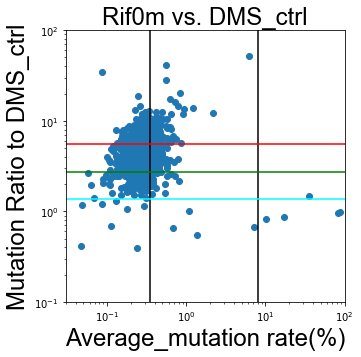

In [34]:
#All AC from datasets
#The values of average mutation rates of DMS_ctrl and Sample_DMS are used as x axis. 
#The ratios between DMS_ctrl and Sample_DMS are used as y axis
  
df_MA=pd.DataFrame({'x': df_U['average_0m'], 'y': df_U['ratio_0m']})

plt.figure(figsize=(5,5))
plt.plot('x','y',data=df_MA,linestyle='none',marker='o')
plt.xlim(0.03,100)
plt.ylim(0.1,100)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Average_mutation rate(%)', fontsize=24, fontname='Arial')
plt.ylabel('Mutation Ratio to DMS_ctrl', fontsize=24,fontname='Arial')
plt.title('Rif0m vs. DMS_ctrl', fontsize=24,fontname='Arial')

plt.axvline(0.35, color='black')
plt.axvline(8, color='black')

#plt.axhline(0.25*ratio_median, color='navy')
#plt.axhline(0.33*ratio_median_AC, color='blue')
plt.axhline(0.5*ratio_median_AC, color='cyan')
plt.axhline(ratio_median_AC, color='green')
plt.axhline(2.0*ratio_median_AC, color='red')
#plt.axhline(3*mean, color='magenta')
#plt.axhline(4*mean, color='red')

plt.savefig('2nd_Rif0m_U_MA_low.pdf',dpi=600)

In [18]:
print ("Rif0m_AC_ratio_50%:", df_AC['ratio_0m'].quantile(0.5))
print ("Rif0m_AC_ratio_92%:",df_AC['ratio_0m'].quantile(0.92))
print ("Rif0m_AC_ratio_8%:",df_AC['ratio_0m'].quantile(0.08))


('Rif0m_AC_ratio_50%:', 2.4948444513051684)
('Rif0m_AC_ratio_92%:', 4.738037932702137)
('Rif0m_AC_ratio_8%:', 1.2594415335710212)


In [19]:
print ("Rif0m_AC_ratio_50%:", df_AC['ratio_0m'].quantile(0.50))

print ("Rif0m_AC_ratio_92%:", df_AC['ratio_0m'].quantile(0.92))
print ("Rif0m_AC_ratio_8%:", df_AC['ratio_0m'].quantile(0.08))
print ("Rif0m_AC_ratio_94%:", df_AC['ratio_0m'].quantile(0.94))
print ("Rif0m_AC_ratio_6%:", df_AC['ratio_0m'].quantile(0.06))

('Rif0m_AC_ratio_50%:', 2.4948444513051684)
('Rif0m_AC_ratio_92%:', 4.738037932702137)
('Rif0m_AC_ratio_8%:', 1.2594415335710212)
('Rif0m_AC_ratio_94%:', 5.062757435217156)
('Rif0m_AC_ratio_6%:', 0.9643803195754822)


# Plot ratio & average to select nucleotides

In [35]:
df_AC.head()

,rRNA,position,nucleotide,ND_ctrl,DMS_ctrl,Rif_0m_DMS,Rif_30s_DMS,Rif_1m_DMS,Rif_2m_DMS,Rif_3m_DMS,...,ratio_10m,ratio_ctrl,average_0m,average_30s,average_1m,average_2m,average_3m,average_5m,average_10m,average_ctrl
0,E.c.16S_rRNA_leader,-147,C,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,E.c.16S_rRNA_leader,-146,A,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,E.c.16S_rRNA_leader,-145,C,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,E.c.16S_rRNA_leader,-142,C,0.0,0.000000,0.0,0.006579,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.328947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,E.c.16S_rRNA_leader,-140,C,0.0,0.012195,0.0,0.005618,0.0,0.0,0.0,...,0.0,0.0,0.609756,0.890655,0.609756,0.609756,0.609756,0.609756,0.609756,0.609756


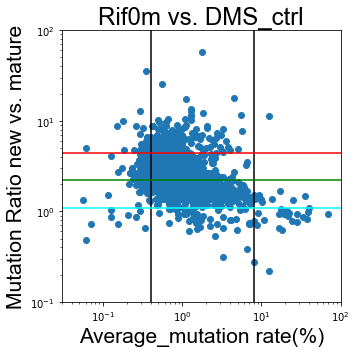

In [49]:
#All AC from datasets
#The values of average mutation rates of DMS_ctrl and Sample_DMS are used as x axis. 
#The ratios between DMS_ctrl and Sample_DMS are used as y axis
  
df_MA=pd.DataFrame({'x': df_AC['average_0m'], 'y': df_AC['ratio_0m']})

plt.figure(figsize=(5,5))
plt.plot('x','y',data=df_MA,linestyle='none',marker='o')
plt.xlim(0.03,100)
plt.ylim(0.1,100)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Average_mutation rate(%)', fontsize=21, fontname='Arial')
plt.ylabel('Mutation Ratio new vs. mature', fontsize=21,fontname='Arial')
plt.title('Rif0m vs. DMS_ctrl', fontsize=24,fontname='Arial')

plt.axvline(0.35, color='black')
plt.axvline(8, color='black')

#plt.axhline(0.25*ratio_median, color='navy')
#plt.axhline(0.33*ratio_median_AC, color='blue')
plt.axhline(0.5*ratio_median_AC, color='cyan')
plt.axhline(ratio_median_AC, color='green')
plt.axhline(2.0*ratio_median_AC, color='red')
#plt.axhline(3*mean, color='magenta')
#plt.axhline(4*mean, color='red')

plt.savefig('2nd_Rif0m_allAC_MA_low_Rif1cal.pdf',dpi=600)



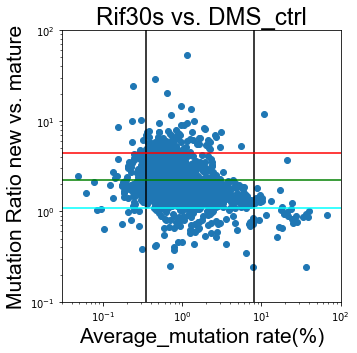

In [52]:
#All AC from datasets
#The values of average mutation rates of DMS_ctrl and Sample_DMS are used as x axis. 
#The ratios between DMS_ctrl and Sample_DMS are used as y axis
  
df_MA=pd.DataFrame({'x': df_AC['average_30s'], 'y': df_AC['ratio_30s']})

plt.figure(figsize=(5,5))
plt.plot('x','y',data=df_MA,linestyle='none',marker='o')
plt.xlim(0.03,100)
plt.ylim(0.1,100)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Average_mutation rate(%)', fontsize=21, fontname='Arial')
plt.ylabel('Mutation Ratio new vs. mature', fontsize=21,fontname='Arial')
plt.title('Rif30s vs. DMS_ctrl', fontsize=24,fontname='Arial')

plt.axvline(0.35, color='black')
plt.axvline(8, color='black')

#ratio_median_AC_30s=df_AC['ratio_1m'].median(axis=0)
#plt.axhline(0.25*ratio_median, color='navy')
#plt.axhline(0.33*ratio_median_AC, color='blue')
plt.axhline(0.5*ratio_median_AC, color='cyan')
plt.axhline(ratio_median_AC, color='green')
plt.axhline(2.0*ratio_median_AC, color='red')
#plt.axhline(3*mean, color='magenta')
#plt.axhline(4*mean, color='red')

plt.savefig('2nd_Rif30s_allAC_MA_low_Rif1cal.pdf',dpi=600)



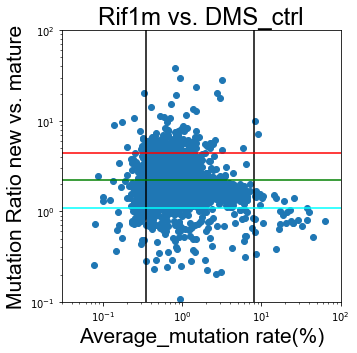

In [53]:
#All AC from datasets
#The values of average mutation rates of DMS_ctrl and Sample_DMS are used as x axis. 
#The ratios between DMS_ctrl and Sample_DMS are used as y axis
  
df_MA=pd.DataFrame({'x': df_AC['average_1m'], 'y': df_AC['ratio_1m']})

plt.figure(figsize=(5,5))
plt.plot('x','y',data=df_MA,linestyle='none',marker='o')
plt.xlim(0.03,100)
plt.ylim(0.1,100)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Average_mutation rate(%)', fontsize=21, fontname='Arial')
plt.ylabel('Mutation Ratio new vs. mature', fontsize=21,fontname='Arial')
plt.title('Rif1m vs. DMS_ctrl', fontsize=24,fontname='Arial')

plt.axvline(0.35, color='black')
plt.axvline(8, color='black')

ratio_median_AC_1m=df_AC['ratio_1m'].median(axis=0)

#plt.axhline(0.25*ratio_median, color='navy')
#plt.axhline(0.33*ratio_median, color='blue')
plt.axhline(0.5*ratio_median_AC_1m, color='cyan')
plt.axhline(ratio_median_AC_1m, color='green')
plt.axhline(2.0*ratio_median_AC_1m, color='red')
#plt.axhline(3*mean, color='magenta')
#plt.axhline(4*mean, color='red')

plt.savefig('2nd_Rif1m_allAC_MA_low_Rif1cal.pdf',dpi=600)



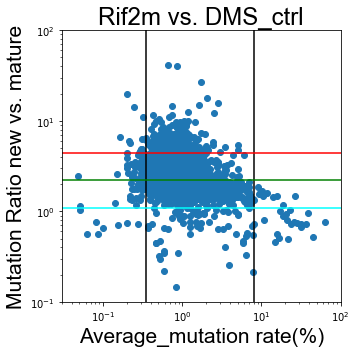

In [55]:
#All AC from datasets
#The values of average mutation rates of DMS_ctrl and Sample_DMS are used as x axis. 
#The ratios between DMS_ctrl and Sample_DMS are used as y axis
  
df_MA=pd.DataFrame({'x': df_AC['average_2m'], 'y': df_AC['ratio_2m']})

plt.figure(figsize=(5,5))
plt.plot('x','y',data=df_MA,linestyle='none',marker='o')
plt.xlim(0.03,100)
plt.ylim(0.1,100)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Average_mutation rate(%)', fontsize=21, fontname='Arial')
plt.ylabel('Mutation Ratio new vs. mature', fontsize=21,fontname='Arial')
plt.title('Rif2m vs. DMS_ctrl', fontsize=24,fontname='Arial')

plt.axvline(0.35, color='black')
plt.axvline(8, color='black')

ratio_median_AC_2m=df_AC['ratio_1m'].median(axis=0)

#plt.axhline(0.25*ratio_median, color='navy')
#plt.axhline(0.33*ratio_median, color='blue')
plt.axhline(0.5*ratio_median_AC_2m, color='cyan')
plt.axhline(ratio_median_AC_2m, color='green')
plt.axhline(2.0*ratio_median_AC_2m, color='red')
#plt.axhline(3*mean, color='magenta')
#plt.axhline(4*mean, color='red')

plt.savefig('2nd_Rif2m_allAC_MA_low_Rif1cal.pdf',dpi=600)



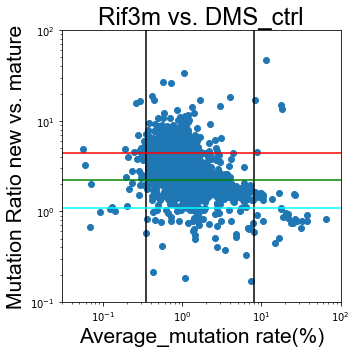

In [56]:
#All AC from datasets
#The values of average mutation rates of DMS_ctrl and Sample_DMS are used as x axis. 
#The ratios between DMS_ctrl and Sample_DMS are used as y axis
  
df_MA=pd.DataFrame({'x': df_AC['average_3m'], 'y': df_AC['ratio_3m']})

plt.figure(figsize=(5,5))
plt.plot('x','y',data=df_MA,linestyle='none',marker='o')
plt.xlim(0.03,100)
plt.ylim(0.1,100)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Average_mutation rate(%)', fontsize=21, fontname='Arial')
plt.ylabel('Mutation Ratio new vs. mature', fontsize=21,fontname='Arial')
plt.title('Rif3m vs. DMS_ctrl', fontsize=24,fontname='Arial')

plt.axvline(0.35, color='black')
plt.axvline(8, color='black')

ratio_median_AC_3m=df_AC['ratio_1m'].median(axis=0)
#plt.axhline(0.25*ratio_median, color='navy')
#plt.axhline(0.33*ratio_median, color='blue')
plt.axhline(0.5*ratio_median_AC_3m, color='cyan')
plt.axhline(ratio_median_AC_3m, color='green')
plt.axhline(2.0*ratio_median_AC_3m, color='red')
#plt.axhline(3*mean, color='magenta')
#plt.axhline(4*mean, color='red')

plt.savefig('2nd_Rif3m_allAC_MA_low_Rif1cal.pdf',dpi=600)



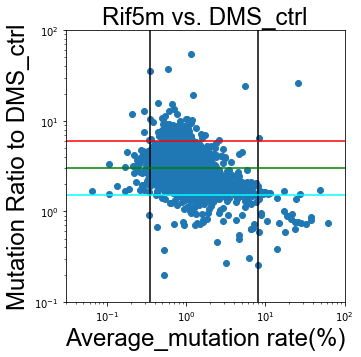

In [26]:
#All AC from datasets
#The values of average mutation rates of DMS_ctrl and Sample_DMS are used as x axis. 
#The ratios between DMS_ctrl and Sample_DMS are used as y axis
  
df_MA=pd.DataFrame({'x': df_AC['average_5m'], 'y': df_AC['ratio_5m']})

plt.figure(figsize=(5,5))
plt.plot('x','y',data=df_MA,linestyle='none',marker='o')
plt.xlim(0.03,100)
plt.ylim(0.1,100)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Average_mutation rate(%)', fontsize=24, fontname='Arial')
plt.ylabel('Mutation Ratio to DMS_ctrl', fontsize=24,fontname='Arial')
plt.title('Rif5m vs. DMS_ctrl', fontsize=24,fontname='Arial')

plt.axvline(0.35, color='black')
plt.axvline(8, color='black')

ratio_median_AC_5m=df_AC['ratio_5m'].median(axis=0)

#plt.axhline(0.25*ratio_median, color='navy')
#plt.axhline(0.33*ratio_median, color='blue')
plt.axhline(0.5*ratio_median_AC_5m, color='cyan')
plt.axhline(ratio_median_AC_5m, color='green')
plt.axhline(2.0*ratio_median_AC_5m, color='red')
#plt.axhline(3*mean, color='magenta')
#plt.axhline(4*mean, color='red')

plt.savefig('2nd_Rif5m_allAC_MA_low.pdf',dpi=600)



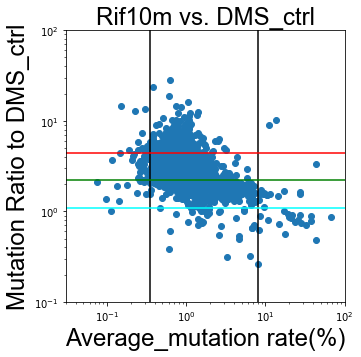

In [57]:
#All AC from datasets
#The values of average mutation rates of DMS_ctrl and Sample_DMS are used as x axis. 
#The ratios between DMS_ctrl and Sample_DMS are used as y axis
  
df_MA=pd.DataFrame({'x': df_AC['average_10m'], 'y': df_AC['ratio_10m']})

plt.figure(figsize=(5,5))
plt.plot('x','y',data=df_MA,linestyle='none',marker='o')
plt.xlim(0.03,100)
plt.ylim(0.1,100)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Average_mutation rate(%)', fontsize=24, fontname='Arial')
plt.ylabel('Mutation Ratio to DMS_ctrl', fontsize=24,fontname='Arial')
plt.title('Rif10m vs. DMS_ctrl', fontsize=24,fontname='Arial')

plt.axvline(0.35, color='black')
plt.axvline(8, color='black')

ratio_median_AC_10m=df_AC['ratio_1m'].median(axis=0)
#plt.axhline(0.25*ratio_median, color='navy')
#plt.axhline(0.33*ratio_median, color='blue')
plt.axhline(0.5*ratio_median_AC_10m, color='cyan')
plt.axhline(ratio_median_AC_10m, color='green')
plt.axhline(2.0*ratio_median_AC_10m, color='red')
#plt.axhline(3*mean, color='magenta')
#plt.axhline(4*mean, color='red')

plt.savefig('2nd_Rif10m_allAC_MA_low_Rif1cal.pdf',dpi=600)



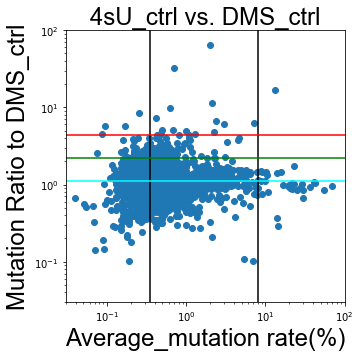

In [59]:
#All AC from datasets
#The values of average mutation rates of DMS_ctrl and Sample_DMS are used as x axis. 
#The ratios between DMS_ctrl and Sample_DMS are used as y axis
  
df_MA=pd.DataFrame({'x': df_AC['average_ctrl'], 'y': df_AC['ratio_ctrl']})

plt.figure(figsize=(5,5))
plt.plot('x','y',data=df_MA,linestyle='none',marker='o')
plt.xlim(0.03,100)
plt.ylim(0.03,100)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Average_mutation rate(%)', fontsize=24, fontname='Arial')
plt.ylabel('Mutation Ratio to DMS_ctrl', fontsize=24,fontname='Arial')
plt.title('4sU_ctrl vs. DMS_ctrl', fontsize=24,fontname='Arial')

plt.axvline(0.35, color='black')
plt.axvline(8, color='black')

ratio_median_AC_ctrl=df_AC['ratio_1m'].median(axis=0)
#plt.axhline(0.25*ratio_median, color='navy')
#plt.axhline(0.33*ratio_median_AC_ctrl, color='blue')
plt.axhline(0.5*ratio_median_AC_ctrl, color='cyan')
plt.axhline(ratio_median_AC_ctrl, color='green')
plt.axhline(2.0*ratio_median_AC_ctrl, color='red')
#plt.axhline(3*mean, color='magenta')
#plt.axhline(4*mean, color='red')

plt.savefig('2nd_4sU_ctrl_allAC_MA_low_Rif1cal.pdf',dpi=600)



# Interactive Bokeh graph for ratio & average

In [60]:
output_file('2nd_Rif_allnt_box_log_Rif1cal.html', title='2nd_Rif_allnt_box_log_Rif1cal')

source = ColumnDataSource(data = df_AC)

# Create a figure with no toolbar and axis ranges of [0,1]
fig = figure(plot_height=600, plot_width=600,
             x_axis_label='Average mutation rate',
             x_axis_type='log',
             x_axis_location='below',
             y_axis_label='Mutation ratio to DMS_ctrl',
             y_axis_type='log',
             y_axis_location='left',
             title='Rif0m_DMS_MA',
             title_location='above',
             toolbar_location= 'right')

# Draw the coordinates as circles
fig.circle(x='average_0m', y='ratio_0m',source = source,color='red', legend ="Rif_0m", size=5, alpha=0.5)

fig.circle(x='average_30s', y='ratio_30s',source = source,color='orange', legend ="Rif_30s", size=5, alpha=0.5)

fig.circle(x='average_1m', y='ratio_1m',source = source,color='yellow', legend ="Rif_1m", size=5, alpha=0.5)

fig.circle(x='average_2m', y='ratio_2m',source = source,color='green', legend ="Rif_2m", size=5, alpha=0.5)

fig.circle(x='average_3m', y='ratio_3m',source = source,color='cyan', legend ="Rif_3m", size=5, alpha=0.5)

fig.circle(x='average_5m', y='ratio_5m',source = source,color='blue', legend ="Rif_5m", size=5, alpha=0.5)

fig.circle(x='average_10m', y='ratio_10m',source = source,color='navy', legend ="Rif_10m", size=5, alpha=0.5)


low_box = BoxAnnotation(left = 0.35, right = 8, top = 0.4 * ratio_median_AC,fill_color='blue', fill_alpha=0.3)
high_box = BoxAnnotation(left = 0.35, right = 8, bottom = 2.5* ratio_median_AC,fill_color='red', fill_alpha=0.3)
mod_box = BoxAnnotation(left = 8, fill_color='yellow', fill_alpha=0.3)
base_box = BoxAnnotation(right = 0.35, fill_color='grey', fill_alpha=0.3)


fig.add_layout(low_box)
fig.add_layout(high_box)
fig.add_layout(mod_box)
fig.add_layout(base_box)

# We write JavaScript to link toggle with visible property of box and line
code = '''\
object.visible = toggle.active
'''

callback1 = CustomJS(code=code, args={})
toggle1 = Toggle(label="Protected nucleotide", button_type="success", callback=callback1)
callback1.args = {'toggle': toggle1, 'object': low_box}

callback2 = CustomJS(code=code, args={})
toggle2 = Toggle(label="Modified nucleotide", button_type="success", callback=callback2)
callback2.args = {'toggle': toggle2, 'object': high_box}

callback3 = CustomJS(code=code, args={})
toggle3 = Toggle(label="High ND values", button_type="success", callback=callback3)
callback3.args = {'toggle': toggle3, 'object': mod_box}


#sample = ['Rif_0m', 'Rif_30s', 'Rif_1m', 'Rif_2m', 'Rif_3m', 'Rif_5m', 'Rif_10m']
tooltips = [('rRNA:', '@rRNA'),('Position:',"@position"),('Nucleotide:',"@nucleotide")]

fig.legend.location = "top_left"
fig.title.text_font = "Arial"
fig.title.align = "center"
fig.add_tools(HoverTool(tooltips=tooltips))

#checkbox_group = CheckboxGroup(labels=["Option 1", "Option 2", "Option 3"], active=[0, 1])

# Show plot
show(layout([fig], [toggle1, toggle2, toggle3]))

#export_png(fig, filename="plot.png")
#fig.savefig(output_file, transparent='True', format='pdf')

# Select nucleotides based on ratio and average values

In [61]:
output_file('2nd_Rif_lowess.html', title='2nd_Rif_0min_lowess')

source = ColumnDataSource(data = df_AC)

# Create a figure with no toolbar and axis ranges of [0,1]
fig = figure(plot_height=600, plot_width=600,
             x_axis_label='Average mutation rate',
             x_axis_type='log',
             x_axis_location='below',
             y_axis_label='Mutation ratio to DMS_ctrl',
             y_axis_type='log',
             y_axis_location='left',
             title='Rif0m_DMS_MA',
             title_location='above',
             toolbar_location= 'right')

# Draw the coordinates as circles
fig.circle(x='average_0m', y='ratio_0m',source = source,color='red', legend ="Rif_0m", size=5, alpha=0.5)

#fig.circle(x='average_30s', y='ratio_30s',source = source,color='orange', legend ="Rif_30s", size=5, alpha=0.5)
#fig.circle(x='average_1m', y='ratio_1m',source = source,color='yellow', legend ="Rif_1m", size=5, alpha=0.5)
#fig.circle(x='average_2m', y='ratio_2m',source = source,color='green', legend ="Rif_2m", size=5, alpha=0.5)
#fig.circle(x='average_3m', y='ratio_3m',source = source,color='cyan', legend ="Rif_3m", size=5, alpha=0.5)
#fig.circle(x='average_5m', y='ratio_5m',source = source,color='blue', legend ="Rif_5m", size=5, alpha=0.5)
#fig.circle(x='average_10m', y='ratio_10m',source = source,color='navy', legend ="Rif_10m", size=5, alpha=0.5)

low_box = BoxAnnotation(left = 0.35, right = 8, top = 0.4 * ratio_median_AC,fill_color='blue', fill_alpha=0.3)
high_box = BoxAnnotation(left = 0.35, right = 8, bottom = 2.5* ratio_median_AC ,fill_color='red', fill_alpha=0.3)
mod_box = BoxAnnotation(left = 8, fill_color='yellow', fill_alpha=0.3)
base_box = BoxAnnotation(right = 0.35, fill_color='grey', fill_alpha=0.3)


fig.add_layout(low_box)
fig.add_layout(high_box)
fig.add_layout(mod_box)
fig.add_layout(base_box)

# We write JavaScript to link toggle with visible property of box and line
code = '''\
object.visible = toggle.active
'''

callback1 = CustomJS(code=code, args={})
toggle1 = Toggle(label="Protected nucleotide", button_type="success", callback=callback1)
callback1.args = {'toggle': toggle1, 'object': low_box}

callback2 = CustomJS(code=code, args={})
toggle2 = Toggle(label="Modified nucleotide", button_type="success", callback=callback2)
callback2.args = {'toggle': toggle2, 'object': high_box}

callback3 = CustomJS(code=code, args={})
toggle3 = Toggle(label="High ND values", button_type="success", callback=callback3)
callback3.args = {'toggle': toggle3, 'object': mod_box}


#sample = ['Rif_0m', 'Rif_30s', 'Rif_1m', 'Rif_2m', 'Rif_3m', 'Rif_5m', 'Rif_10m']
tooltips = [('rRNA:', '@rRNA'),('Position:',"@position"),('Nucleotide:',"@nucleotide")]

fig.legend.location = "top_left"
fig.title.text_font = "Arial"
fig.title.align = "center"
fig.add_tools(HoverTool(tooltips=tooltips))

#checkbox_group = CheckboxGroup(labels=["Option 1", "Option 2", "Option 3"], active=[0, 1])

# Show plot
show(layout([fig], [toggle1, toggle2, toggle3]))

#export_png(fig, filename="plot.png")
#fig.savefig(output_file, transparent='True', format='pdf')

# 16S

In [62]:
df_16S = df_AC[df_AC.rRNA == 'E.c.16S_rRNA']

df_16S.head()

,rRNA,position,nucleotide,ND_ctrl,DMS_ctrl,Rif_0m_DMS,Rif_30s_DMS,Rif_1m_DMS,Rif_2m_DMS,Rif_3m_DMS,...,ratio_10m,ratio_ctrl,average_0m,average_30s,average_1m,average_2m,average_3m,average_5m,average_10m,average_ctrl
147,E.c.16S_rRNA,1,A,0.000126,0.000189,0.006726,0.004620,0.000000,0.003762,0.000935,...,14.715906,0.000000,0.345787,0.240487,0.009464,0.197576,0.056193,0.345787,0.148740,0.009464
148,E.c.16S_rRNA,2,A,0.000000,0.000420,0.010613,0.022222,0.015982,0.016861,0.011146,...,28.545660,32.690012,0.551654,1.132105,0.820080,0.864054,0.578318,1.156659,0.620264,0.707268
149,E.c.16S_rRNA,3,A,0.000000,0.000309,0.002672,0.008855,0.006304,0.012736,0.004828,...,23.528800,4.525022,0.149051,0.458190,0.330619,0.652225,0.256849,0.584458,0.378541,0.085265
153,E.c.16S_rRNA,7,A,0.000672,0.024140,0.028520,0.023487,0.018653,0.034262,0.030000,...,1.366008,0.705973,2.633009,2.381373,2.139662,2.920090,2.707007,3.035132,2.855787,2.059121
154,E.c.16S_rRNA,8,A,0.000349,0.009853,0.017229,0.010041,0.017687,0.013965,0.018018,...,1.878168,0.991565,1.354125,0.994700,1.377019,1.190923,1.393551,1.367121,1.417929,0.981144


In [95]:
ratio_median_AC=df_AC['ratio_30s'].median(axis=0)

In [96]:
#Now cluster Rif_0m_DMS based on ratio values


df_sam_C = df_16S[(df_16S['DMS_ctrl']> 8) & (df_16S['ratio_0m'] <2*ratio_median_AC) 
                    & (df_16S['ratio_0m'] >0.4*ratio_median_AC)]

df_sam_5 = df_16S[(df_16S['average_0m']> 0.35) & (df_16S['ratio_0m'] >5*ratio_median_AC)]

df_sam_4 = df_16S[(df_16S['average_0m']> 0.35) & (df_16S['ratio_0m'] >4*ratio_median_AC)
                    & (df_16S['ratio_0m'] <5*ratio_median_AC)]

df_sam_3 = df_16S[(df_16S['average_0m']> 0.35) & (df_16S['ratio_0m'] >3*ratio_median_AC)
                    & (df_16S['ratio_0m'] <4*ratio_median_AC)]

df_sam_2 = df_16S[(df_16S['average_0m']> 0.35) & (df_16S['ratio_0m'] >2.0*ratio_median_AC)
                    & (df_16S['ratio_0m'] <3*ratio_median_AC)]

df_sam_P1 = df_16S[(df_16S['average_0m']> 0.35) & (df_16S['ratio_0m'] >0.33*ratio_median_AC)
                    & (df_16S['ratio_0m'] <0.5*ratio_median_AC)]

df_sam_P2 = df_16S[(df_16S['average_0m']> 0.35) & (df_16S['ratio_0m'] >0.25*ratio_median_AC)
                    & (df_16S['ratio_0m'] <0.33*ratio_median_AC)]

df_sam_P3 = df_16S[(df_16S['average_0m']> 0.35) & (df_16S['ratio_0m'] >0.20*ratio_median_AC)
                    & (df_16S['ratio_0m'] <0.25*ratio_median_AC)]

df_sam_P4 = df_16S[(df_16S['average_0m']> 0.35) & (df_16S['ratio_0m'] <0.20*ratio_median_AC)]

sam_C = df_sam_C['position'].tolist()
sam_5 = df_sam_5['position'].tolist()
sam_4 = df_sam_4['position'].tolist()
sam_3 = df_sam_3['position'].tolist()
sam_2 = df_sam_2['position'].tolist()

sam_P1 = df_sam_P1['position'].tolist()
sam_P2 = df_sam_P2['position'].tolist()
sam_P3 = df_sam_P3['position'].tolist()
sam_P4 = df_sam_P4['position'].tolist()

print ("Rif0_high_values:", sam_C)
print ("Rif0_high_ratio:", sam_5)
print ("Rif0_mid_ratio:", sam_4)
print ("Rif0_low_ratio:", sam_3)
print ("Rif0_lower_ratio:", sam_2)

print ("Rif0_protected_1:", sam_P1)
print ("Rif0_protected_2:", sam_P2)
print ("Rif0_protected_3:", sam_P3)
print ("Rif0_protected_4:", sam_P4)


('Rif0_high_values:', [])
('Rif0_high_ratio:', [2])
('Rif0_mid_ratio:', [704, 1251])
('Rif0_low_ratio:', [206, 339, 511, 623, 642, 643, 862, 1289])
('Rif0_lower_ratio:', [54, 73, 99, 132, 153, 156, 172, 175, 182, 196, 197, 207, 282, 290, 295, 322, 374, 436, 496, 498, 499, 501, 536, 595, 596, 608, 621, 640, 648, 649, 655, 687, 728, 743, 749, 817, 825, 826, 872, 873, 910, 990, 1011, 1037, 1103, 1172, 1176, 1209, 1246, 1248, 1249, 1250, 1282, 1288, 1314, 1320, 1325, 1389, 1409, 1484, 1535])
('Rif0_protected_1:', [90, 93, 183, 250, 400, 401, 892, 908, 909, 915, 1038, 1281, 1402, 1408, 1539, 1542])
('Rif0_protected_2:', [253, 271, 272, 856])
('Rif0_protected_3:', [])
('Rif0_protected_4:', [1519])


In [97]:
# Now we can generate xRNA files through list, this is for 16S only
# Need to modify code such that points at the ends of the RNA aren't included 
# (i.e. 1 and 1542 on 16S and 1, 1646, 1647, and 2904 on 23S)

#f = open("DMS_ctrl_16S_cluster.txt", "r")
#contents = f.readlines()

cluster1=sam_C
cluster2=sam_5
cluster3=sam_4
cluster4=sam_3
cluster5=sam_2
cluster6=sam_P1
cluster7=sam_P2
cluster8=sam_P3
cluster9=sam_P4

#xrna_RNAs = ['E.c.16S_rRNA', 'E.c.23S__rRNA', 'E.c.5S___rRNA']
#expt_samples = ['Stationary_0_norm','Stationary_1_norm','Stationary_5_norm','Stationary_18_norm','Stationary_27_norm','Stationary_44_norm','Stationary_60_norm','Stationary_72_norm','Stationary_90_norm']
xrna_RNAs = ['E.c.16S_rRNA']
#expt_samples = ['Rif1_1_norm','Rif1_2_norm','Rif1_3_norm','Rif1_4_norm','Rif1_5_norm','Rif1_6_norm','Rif1_post_norm']

# Open reference xrna file and write new xrna files.
xrna_file = open("2ndRif_Rif0_cluster_16S_2.0_0.5_Rif1cal.xrna", 'w')                                          
reference_xrna_script_file = open('xrna_base_script_16s.xrna') # Need to change rRNA reference.       

for line in reference_xrna_script_file:
        if line.startswith('#<insert colored nucleotides>'):
            for i in range(1,1542):
                if i in cluster1:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='808080'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                                
                #Perturbed nucleotides
                elif i in cluster2:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='800000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster3:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff0000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster4:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff748c'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
        
                elif i in cluster5:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffc0cb'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                #Protected nucleotides    
                elif i in cluster6:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='cbe2ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster7:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='b2b2ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster8:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='0000ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                
                elif i in cluster9:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='000099'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
          
        else:
            xrna_file.write(line)


reference_xrna_script_file.close()
xrna_file.close() 

# 23S

In [21]:
df_23S = df_AC[df_AC.rRNA == 'E.c.23S__rRNA']

df_23S.head()

,rRNA,position,nucleotide,ND_ctrl,DMS_ctrl,Rif_0m_DMS,Rif_30s_DMS,Rif_1m_DMS,Rif_2m_DMS,Rif_3m_DMS,...,ratio_10m,ratio_ctrl,average_0m,average_30s,average_1m,average_2m,average_3m,average_5m,average_10m,average_ctrl
1859,E.c.23S__rRNA,5,A,0.000261,0.001393,0.002800,0.005005,0.008248,0.006794,0.001424,...,2.718620,0.841083,0.209613,0.319876,0.482037,0.409349,0.140806,0.191527,0.258911,0.128186
1860,E.c.23S__rRNA,6,A,0.000360,0.002394,0.004138,0.004722,0.005245,0.002785,0.005708,...,1.572591,0.257172,0.326637,0.355835,0.381976,0.258965,0.405122,0.348441,0.307986,0.150506
1862,E.c.23S__rRNA,8,C,0.002240,0.003934,0.005388,0.005363,0.005621,0.007368,0.003207,...,1.883147,0.826879,0.466095,0.464879,0.477776,0.565104,0.357047,0.529577,0.567136,0.359360
1864,E.c.23S__rRNA,10,A,0.000887,0.012646,0.014424,0.014025,0.016732,0.019416,0.018285,...,1.567194,0.642048,1.353491,1.333545,1.468868,1.603063,1.546537,1.696775,1.623204,1.038246
1865,E.c.23S__rRNA,11,C,0.002004,0.012513,0.017000,0.014947,0.016317,0.021042,0.021439,...,1.715180,0.674980,1.475687,1.373021,1.441509,1.677778,1.697596,1.621734,1.698799,1.047980


In [39]:
ratio_median_AC=df_AC['ratio_30s'].median(axis=0)

In [52]:
#Now cluster Rif_10m_DMS based on ratio values


df_sam_C = df_23S[(df_23S['DMS_ctrl']> 8) & (df_23S['ratio_10m'] <2*ratio_median_AC) 
                    & (df_23S['ratio_10m'] >0.5*ratio_median_AC)]

df_sam_5 = df_23S[(df_23S['average_10m']> 0.35) & (df_23S['ratio_10m'] >5*ratio_median_AC)]

df_sam_4 = df_23S[(df_23S['average_10m']> 0.35) & (df_23S['ratio_10m'] >4*ratio_median_AC)
                    & (df_23S['ratio_10m'] <5*ratio_median_AC)]

df_sam_3 = df_23S[(df_23S['average_10m']> 0.35) & (df_23S['ratio_10m'] >3*ratio_median_AC)
                    & (df_23S['ratio_10m'] <4*ratio_median_AC)]

df_sam_2 = df_23S[(df_23S['average_10m']> 0.35) & (df_23S['ratio_10m'] >2*ratio_median_AC)
                    & (df_23S['ratio_10m'] <3*ratio_median_AC)]

df_sam_P1 = df_23S[(df_23S['average_10m']> 0.35) & (df_23S['ratio_10m'] >0.33*ratio_median_AC)
                    & (df_23S['ratio_10m'] <0.5*ratio_median_AC)]

df_sam_P2 = df_23S[(df_23S['average_10m']> 0.35) & (df_23S['ratio_10m'] >0.25*ratio_median_AC)
                    & (df_23S['ratio_10m'] <0.33*ratio_median_AC)]

df_sam_P3 = df_23S[(df_23S['average_10m']> 0.35) & (df_23S['ratio_10m'] >0.20*ratio_median_AC)
                    & (df_23S['ratio_10m'] <0.25*ratio_median_AC)]

df_sam_P4 = df_23S[(df_23S['average_10m']> 0.35) & (df_23S['ratio_10m'] <0.20*ratio_median_AC)]

sam_C = df_sam_C['position'].tolist()
sam_5 = df_sam_5['position'].tolist()
sam_4 = df_sam_4['position'].tolist()
sam_3 = df_sam_3['position'].tolist()
sam_2 = df_sam_2['position'].tolist()

sam_P1 = df_sam_P1['position'].tolist()
sam_P2 = df_sam_P2['position'].tolist()
sam_P3 = df_sam_P3['position'].tolist()
sam_P4 = df_sam_P4['position'].tolist()

print ("Rif10m_high_values:", sam_C)
print ("Rif10m_high_ratio:", sam_5)
print ("Rif10m_mid_ratio:", sam_4)
print ("Rif10m_low_ratio:", sam_3)
print ("Rif10m_lower_ratio:", sam_2)

print ("Rif10m_protected_1:", sam_P1)
print ("Rif10m_protected_2:", sam_P2)
print ("Rif10m_protected_3:", sam_P3)
print ("Rif10m_protected_4:", sam_P4)

('Rif10m_high_values:', [])
('Rif10m_high_ratio:', [1000, 1305, 1691, 2527, 2880, 2896])
('Rif10m_mid_ratio:', [1080, 1085, 1533, 1550, 1561, 1774, 1795, 1804, 2091, 2200])
('Rif10m_low_ratio:', [105, 145, 157, 192, 198, 426, 433, 461, 516, 527, 557, 634, 671, 678, 719, 723, 823, 912, 1057, 1084, 1086, 1135, 1140, 1172, 1221, 1353, 1531, 1564, 1565, 1656, 1788, 1790, 1802, 1806, 2006, 2078, 2129, 2143, 2150, 2403, 2517, 2805])
('Rif10m_lower_ratio:', [41, 47, 49, 57, 66, 83, 84, 96, 106, 119, 129, 143, 147, 149, 151, 152, 155, 179, 183, 208, 225, 228, 246, 302, 323, 341, 353, 383, 385, 398, 417, 418, 440, 479, 480, 507, 523, 531, 540, 544, 564, 595, 599, 601, 608, 610, 637, 645, 655, 666, 687, 692, 693, 698, 740, 765, 787, 791, 794, 812, 819, 829, 833, 840, 867, 877, 893, 921, 937, 946, 957, 961, 968, 972, 975, 995, 998, 1001, 1007, 1009, 1021, 1030, 1053, 1076, 1077, 1088, 1100, 1103, 1104, 1111, 1118, 1145, 1150, 1155, 1170, 1208, 1254, 1261, 1276, 1319, 1320, 1323, 1335, 1336, 1351,

In [53]:
# Now we can generate xRNA files through list, this is for 16S only
# Need to modify code such that points at the ends of the RNA aren't included 
# (i.e. 1 and 1542 on 16S and 1, 1646, 1647, and 2904 on 23S)

#f = open("DMS_ctrl_16S_cluster.txt", "r")
#contents = f.readlines()

cluster1=sam_C
cluster2=sam_5
cluster3=sam_4
cluster4=sam_3
cluster5=sam_2
cluster6=sam_P1
cluster7=sam_P2
cluster8=sam_P3
cluster9=sam_P4

#xrna_RNAs = ['E.c.16S_rRNA', 'E.c.23S__rRNA', 'E.c.5S___rRNA']
#expt_samples = ['Stationary_0_norm','Stationary_1_norm','Stationary_5_norm','Stationary_18_norm','Stationary_27_norm','Stationary_44_norm','Stationary_60_norm','Stationary_72_norm','Stationary_90_norm']
xrna_RNAs = ['E.c.23S_rRNA']
#expt_samples = ['Rif1_1_norm','Rif1_2_norm','Rif1_3_norm','Rif1_4_norm','Rif1_5_norm','Rif1_6_norm','Rif1_post_norm']

# Open reference xrna file and write new xrna files.
xrna_file = open("Rif10m_DMS_cluster_23S_2_0.5_Rif30cal.xrna", 'w')                                          
reference_xrna_script_file = open('xrna_base_script_23s.xrna') # Need to change rRNA reference.       

for line in reference_xrna_script_file:
        if line.startswith('#<insert colored nucleotides>'):
            for i in range(1,1646):
                if i in cluster1:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='808080'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                                
                #Perturbed nucleotides
                elif i in cluster2:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='800000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster3:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff0000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster4:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff748c'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
        
                elif i in cluster5:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffc0cb'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                #Protected nucleotides    
                elif i in cluster6:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='cbe2ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster7:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='b2b2ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster8:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='0000ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                
                elif i in cluster9:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='000099'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
          
        elif line.startswith('#<insert remaining colored nucleotides>'):
            for i in range(1647,2904):
                if i in cluster1:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='808080'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster2:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='800000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster3:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff0000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster4:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff748c'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
        
                elif i in cluster5:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffc0cb'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                
                elif i in cluster6:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='cbe2ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                        
                elif i in cluster7:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='b2b2ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                
                elif i in cluster8:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='0000ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                
                elif i in cluster9:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='000099'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                
                else:
                    pass
          
        else:
            xrna_file.write(line)


reference_xrna_script_file.close()
xrna_file.close() 

# 5S

In [143]:
df_5S = df_AC[df_AC.rRNA == 'E.c.5S___rRNA']

df_5S.head()

,rRNA,position,nucleotide,ND_ctrl,DMS_ctrl,Rif_0m_DMS,Rif_30s_DMS,Rif_1m_DMS,Rif_2m_DMS,Rif_3m_DMS,...,ratio_10m,ratio_ctrl,average_0m,average_30s,average_1m,average_2m,average_3m,average_5m,average_10m,average_ctrl
4854,E.c.5S___rRNA,3,C,0.000756,0.000278,0.000000,0.000688,0.002495,0.000683,0.000903,...,0.000000,5.680390,0.013906,0.048309,0.138633,0.048059,0.059073,0.013906,0.013906,0.092895
4855,E.c.5S___rRNA,4,C,0.000241,0.000200,0.001004,0.000000,0.000000,0.000212,0.000000,...,0.000000,0.000000,0.060215,0.010019,0.010019,0.020635,0.010019,0.010019,0.010019,0.010019
4859,E.c.5S___rRNA,8,C,0.003512,0.004489,0.005222,0.004693,0.003287,0.002925,0.005291,...,1.078782,0.245584,0.485545,0.459098,0.388775,0.370695,0.488999,0.670248,0.466579,0.279569
4862,E.c.5S___rRNA,11,C,0.003333,0.013668,0.018363,0.018494,0.019291,0.020028,0.015096,...,1.296391,0.626135,1.601558,1.608065,1.647925,1.684762,1.438180,1.532320,1.569322,1.111278
4863,E.c.5S___rRNA,12,C,0.070967,0.083795,0.062157,0.071359,0.044645,0.045413,0.053781,...,0.688162,0.527681,7.297569,7.757678,6.421997,6.460378,6.878770,7.259335,7.072940,6.400567


In [158]:
ratio_median_AC=df_AC['ratio_30s'].median(axis=0)

In [159]:
#Now cluster Rif_0m_DMS based on ratio values
df_sam_C = df_5S[(df_5S['DMS_ctrl']> 8) & (df_5S['ratio_0m'] <2*ratio_median_AC) 
                    & (df_5S['ratio_0m'] >0.4*ratio_median_AC)]

df_sam_5 = df_5S[(df_5S['average_0m']> 0.35) & (df_5S['ratio_0m'] >5*ratio_median_AC)]

df_sam_4 = df_5S[(df_5S['average_0m']> 0.35) & (df_5S['ratio_0m'] >4*ratio_median_AC)
                    & (df_5S['ratio_0m'] <5*ratio_median_AC)]

df_sam_3 = df_5S[(df_5S['average_0m']> 0.35) & (df_5S['ratio_0m'] >3*ratio_median_AC)
                    & (df_5S['ratio_0m'] <4*ratio_median_AC)]

df_sam_2 = df_5S[(df_5S['average_0m']> 0.35) & (df_5S['ratio_0m'] >2*ratio_median_AC)
                    & (df_5S['ratio_0m'] <3*ratio_median_AC)]

df_sam_P1 = df_5S[(df_5S['average_0m']> 0.35) & (df_5S['ratio_0m'] >0.33*ratio_median_AC)
                    & (df_5S['ratio_0m'] <0.5*ratio_median_AC)]

df_sam_P2 = df_5S[(df_5S['average_0m']> 0.35) & (df_5S['ratio_0m'] >0.25*ratio_median_AC)
                    & (df_5S['ratio_0m'] <0.33*ratio_median_AC)]

df_sam_P3 = df_5S[(df_5S['average_0m']> 0.35) & (df_5S['ratio_0m'] >0.20*ratio_median_AC)
                    & (df_5S['ratio_0m'] <0.25*ratio_median_AC)]

df_sam_P4 = df_5S[(df_5S['average_0m']> 0.35) & (df_5S['ratio_0m'] <0.20*ratio_median_AC)]

sam_C = df_sam_C['position'].tolist()
sam_5 = df_sam_5['position'].tolist()
sam_4 = df_sam_4['position'].tolist()
sam_3 = df_sam_3['position'].tolist()
sam_2 = df_sam_2['position'].tolist()

sam_P1 = df_sam_P1['position'].tolist()
sam_P2 = df_sam_P2['position'].tolist()
sam_P3 = df_sam_P3['position'].tolist()
sam_P4 = df_sam_P4['position'].tolist()

print ("Rif0m_high_values:", sam_C)
print ("Rif0m_high_ratio:", sam_5)
print ("Rif0m_mid_ratio:", sam_4)
print ("Rif0m_low_ratio:", sam_3)
print ("Rif0m_lower_ratio:", sam_2)

print ("Rif0_protected_1:", sam_P1)
print ("Rif0_protected_2:", sam_P2)
print ("Rif0_protected_3:", sam_P3)
print ("Rif0_protected_4:", sam_P4)

('Rif0_high_values:', [])
('Rif0_high_ratio:', [114])
('Rif0_mid_ratio:', [47])
('Rif0_low_ratio:', [58])
('Rif0_lower_ratio:', [46, 49, 60, 110, 113])
('Rif0_protected_1:', [12])
('Rif0_protected_2:', [])
('Rif0_protected_3:', [])
('Rif0_protected_4:', [])


In [160]:
# Now we can generate xRNA files through list, this is for 16S only
# Need to modify code such that points at the ends of the RNA aren't included 
# (i.e. 1 and 1542 on 16S and 1, 1646, 1647, and 2904 on 23S)

#f = open("DMS_ctrl_16S_cluster.txt", "r")
#contents = f.readlines()

cluster1=sam_C
cluster2=sam_5
cluster3=sam_4
cluster4=sam_3
cluster5=sam_2
cluster6=sam_P1
cluster7=sam_P2
cluster8=sam_P3
cluster9=sam_P4

#xrna_RNAs = ['E.c.16S_rRNA', 'E.c.23S__rRNA', 'E.c.5S___rRNA']
#expt_samples = ['Stationary_0_norm','Stationary_1_norm','Stationary_5_norm','Stationary_18_norm','Stationary_27_norm','Stationary_44_norm','Stationary_60_norm','Stationary_72_norm','Stationary_90_norm']
xrna_RNAs = ['E.c.5S_rRNA']
#expt_samples = ['Rif1_1_norm','Rif1_2_norm','Rif1_3_norm','Rif1_4_norm','Rif1_5_norm','Rif1_6_norm','Rif1_post_norm']

# Open reference xrna file and write new xrna files.
xrna_file = open("Rif0m_cluster_5S_2_0.5_Rif30cal.xrna", 'w')                                          
reference_xrna_script_file = open('xrna_base_script_5s.xrna') # Need to change rRNA reference.       

for line in reference_xrna_script_file:
        if line.startswith('#<insert colored nucleotides>'):
            for i in range(1,120):
                if i in cluster1:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='808080'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                                
                #Perturbed nucleotides
                elif i in cluster2:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='800000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster3:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff0000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster4:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff748c'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
        
                elif i in cluster5:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffc0cb'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                #Protected nucleotides    
                elif i in cluster6:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='cbe2ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster7:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='b2b2ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster8:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='0000ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                
                elif i in cluster9:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='000099'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
          
        else:
            xrna_file.write(line)


reference_xrna_script_file.close()
xrna_file.close() 

# trajectory clustering

In [54]:
ratio_median_AC=df_AC['ratio_30s'].median(axis=0)

In [55]:
#select all nucleotides that fill the criteria
Ratio_values = ['Rif1_DMS_avg','Rif0_ratio','Rif30s_ratio','Rif1_ratio','Rif2_ratio','Rif3_ratio',
                'Rif5_ratio','Rif10_ratio']

df_Rif0_perturbed = df_AC[(df_AC['average_0m']> 0.35) & (df_AC['ratio_0m'] > 2.0*ratio_median_AC)]
df_Rif30s_perturbed = df_AC[(df_AC['average_30s']> 0.35) & (df_AC['ratio_30s'] > 2.0*ratio_median_AC)]
df_Rif1_perturbed = df_AC[(df_AC['average_1m']> 0.35) & (df_AC['ratio_1m'] > 2.0*ratio_median_AC)]
df_Rif2_perturbed = df_AC[(df_AC['average_2m']> 0.35) & (df_AC['ratio_2m'] > 2.0*ratio_median_AC)]
#df_Rif3_perturbed = df_AC[(df_AC['average_3m']> 0.35) & (df_AC['ratio_3m'] > 2*ratio_median_AC)]
#df_Rif5_perturbed = df_AC[(df_AC['average_5m']> 0.35) & (df_AC['ratio_5m'] > 2*ratio_median_AC)]
#df_Rif10_perturbed = df_AC[(df_AC['average_10m']> 0.35) & (df_AC['ratio_10m'] > 2*ratio_median_AC)]

df_Rif0_protected = df_AC[(df_AC['average_0m']> 0.35) & (df_AC['ratio_0m'] < 0.5*ratio_median_AC)]
df_Rif30s_protected = df_AC[(df_AC['average_30s']> 0.35) & (df_AC['ratio_30s'] < 0.5*ratio_median_AC)]
df_Rif1_protected = df_AC[(df_AC['average_1m']> 0.35) & (df_AC['ratio_1m'] < 0.5*ratio_median_AC)]
df_Rif2_protected = df_AC[(df_AC['average_2m']> 0.35) & (df_AC['ratio_2m'] < 0.5*ratio_median_AC)]
#df_Rif3_protected = df_AC[(df_AC['average_3m']> 0.35) & (df_AC['ratio_3m'] < 0.4*ratio_median_AC)]
#df_Rif5_protected = df_AC[(df_AC['average_5m']> 0.35) & (df_AC['ratio_5m'] < 0.4*ratio_median_AC)]
#df_Rif10_protected = df_AC[(df_AC['average_10m']> 0.35) & (df_AC['ratio_10m'] < 0.4*ratio_median_AC)]

#merged_df = pd.concat([df1, df2])

df_Rif_enhanced = pd.concat([df_Rif0_perturbed, df_Rif30s_perturbed,df_Rif1_perturbed,df_Rif2_perturbed])
#                                  df_Rif3_perturbed,df_Rif5_perturbed,df_Rif10_perturbed])

#df_Rif_23S_perturbed.drop_duplicates()
df_Rif_enhanced.sort_values("position", inplace = True)
df_Rif_enhanced.drop_duplicates(keep = "first", inplace = True)

df_Rif_enhanced.to_csv('2ndRif_DMS_ratio_enhanced_2.0_Rif30cal.csv')

df_Rif_protected = pd.concat([df_Rif0_protected, df_Rif30s_protected,df_Rif1_protected,
                                  df_Rif2_protected])
#df_Rif3_protected,df_Rif5_protected,df_Rif10_protected])

df_Rif_protected.sort_values("position", inplace = True)
df_Rif_protected.drop_duplicates(keep = "first", inplace = True)

df_Rif_protected.to_csv('2ndRif_DMS_ratio_protected_0.5_Rif30cal.csv')

In [56]:
df_Rif_enhanced.head()

,rRNA,position,nucleotide,ND_ctrl,DMS_ctrl,Rif_0m_DMS,Rif_30s_DMS,Rif_1m_DMS,Rif_2m_DMS,Rif_3m_DMS,...,ratio_10m,ratio_ctrl,average_0m,average_30s,average_1m,average_2m,average_3m,average_5m,average_10m,average_ctrl
11,E.c.16S_rRNA_leader,-136,A,0.0,0.000000,0.062500,0.004132,0.000000,0.0,0.0,...,NaN,NaN,3.125000,0.206612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,E.c.16S_rRNA_leader,-134,C,0.0,0.000000,0.000000,0.023569,0.000000,0.0,0.0,...,NaN,NaN,0.000000,1.178451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,E.c.16S_rRNA_leader,-132,A,0.0,0.015038,0.038462,0.025496,0.148936,0.0,0.0,...,0.0,0.0,2.674957,2.026667,8.198688,0.751880,0.751880,0.751880,0.751880,0.751880
19,E.c.16S_rRNA_leader,-128,A,0.0,0.000000,0.034483,0.008163,0.022989,0.0,0.0,...,NaN,NaN,1.724138,0.408163,1.149425,0.000000,0.000000,0.000000,0.000000,0.000000
21,E.c.16S_rRNA_leader,-126,C,0.0,0.021978,0.032258,0.020221,0.159091,0.0,0.0,...,0.0,0.0,2.711804,2.109930,9.053447,1.098901,1.098901,1.098901,1.098901,1.098901


In [57]:
pd.set_option('use_inf_as_na', True)
df_Rif_enhanced.dropna(inplace=True)

In [58]:
df_Rif_enhanced['diff1']=df_Rif_enhanced.ratio_30s-df_Rif_enhanced.ratio_0m
df_Rif_enhanced['diff2']=df_Rif_enhanced.ratio_1m-df_Rif_enhanced.ratio_30s
df_Rif_enhanced['diff3']=df_Rif_enhanced.ratio_2m-df_Rif_enhanced.ratio_1m

In [68]:
df_Rif_enhanced.cluster1 = df_Rif_enhanced[df_Rif_enhanced['diff1']<0]
df_Rif_enhanced.cluster2 = df_Rif_enhanced[(df_Rif_enhanced['diff1']>=0) & (df_Rif_enhanced['diff2']<0)]
df_Rif_enhanced.cluster3 = df_Rif_enhanced[(df_Rif_enhanced['diff1']>=0) & (df_Rif_enhanced['diff2']>=0)& 
                                           (df_Rif_enhanced['diff3']<0)]
df_Rif_enhanced.cluster4 = df_Rif_enhanced[(df_Rif_enhanced['diff1']>=0) & (df_Rif_enhanced['diff2']>=0)& 
                                           (df_Rif_enhanced['diff3']>=0)]

df_Rif_enhanced.cluster1.to_csv('2ndRif_enhanced_cluster1_2.0_Rif30cal.csv')
df_Rif_enhanced.cluster2.to_csv('2ndRif_enhanced_cluster2_2.0_Rif30cal.csv')
df_Rif_enhanced.cluster3.to_csv('2ndRif_enhanced_cluster3_2.0_Rif30cal.csv')
df_Rif_enhanced.cluster4.to_csv('2ndRif_enhanced_cluster4_2.0_Rif30cal.csv')

In [70]:
df_Rif_protected['diff1']=df_Rif_protected.ratio_30s-df_Rif_protected.ratio_0m
df_Rif_protected['diff2']=df_Rif_protected.ratio_1m-df_Rif_protected.ratio_30s
df_Rif_protected['diff3']=df_Rif_protected.ratio_2m-df_Rif_protected.ratio_1m

In [71]:
df_Rif_protected.cluster1 = df_Rif_protected[df_Rif_protected['diff1']>0]
df_Rif_protected.cluster2 = df_Rif_protected[(df_Rif_protected['diff1']<=0) & (df_Rif_protected['diff2']>0)]
df_Rif_protected.cluster3 = df_Rif_protected[(df_Rif_protected['diff1']<=0) & (df_Rif_protected['diff2']<=0)& 
                                           (df_Rif_protected['diff3']>0)]
df_Rif_protected.cluster4 = df_Rif_protected[(df_Rif_protected['diff1']<=0) & (df_Rif_protected['diff2']<=0)& 
                                           (df_Rif_protected['diff3']<=0)]

df_Rif_protected.cluster1.to_csv('2ndRif_protected_cluster1_0.5_Rif30cal.csv')
df_Rif_protected.cluster2.to_csv('2ndRif_protected_cluster2_0.5_Rif30cal.csv')
df_Rif_protected.cluster3.to_csv('2ndRif_protected_cluster3_0.5_Rif30cal.csv')
df_Rif_protected.cluster4.to_csv('2ndRif_protected_cluster4_0.5_Rif30cal.csv')


## 16S_trajectory clustering

In [62]:
df_16S_enhanced_cluster1=df_Rif_enhanced.cluster1[df_Rif_enhanced.cluster1.rRNA == 'E.c.16S_rRNA']
df_16S_enhanced_cluster2=df_Rif_enhanced.cluster2[df_Rif_enhanced.cluster2.rRNA == 'E.c.16S_rRNA']
df_16S_enhanced_cluster3=df_Rif_enhanced.cluster3[df_Rif_enhanced.cluster3.rRNA == 'E.c.16S_rRNA']
df_16S_enhanced_cluster4=df_Rif_enhanced.cluster4[df_Rif_enhanced.cluster4.rRNA == 'E.c.16S_rRNA']

enhanced_cluster1_16S =  df_16S_enhanced_cluster1['position'].tolist()
enhanced_cluster2_16S =  df_16S_enhanced_cluster2['position'].tolist()
enhanced_cluster3_16S =  df_16S_enhanced_cluster3['position'].tolist()
enhanced_cluster4_16S =  df_16S_enhanced_cluster4['position'].tolist()

print ('enhanced_cluster1_16S:', enhanced_cluster1_16S)
print ('enhanced_cluster2_16S:', enhanced_cluster2_16S)
print ('enhanced_cluster3_16S:', enhanced_cluster3_16S)
print ('enhanced_cluster4_16S:', enhanced_cluster4_16S)

('enhanced_cluster1_16S:', [54, 60, 67, 72, 73, 78, 99, 101, 132, 153, 156, 169, 172, 175, 179, 182, 195, 196, 197, 207, 217, 223, 225, 236, 277, 279, 282, 290, 320, 322, 339, 372, 374, 419, 436, 466, 496, 498, 499, 501, 507, 509, 510, 511, 533, 536, 539, 545, 553, 572, 573, 595, 596, 608, 609, 618, 621, 622, 623, 631, 637, 640, 642, 643, 648, 649, 651, 655, 658, 663, 687, 704, 728, 743, 744, 746, 749, 754, 756, 783, 817, 825, 826, 862, 872, 873, 878, 883, 897, 910, 914, 948, 949, 984, 985, 990, 1037, 1081, 1082, 1103, 1112, 1119, 1147, 1151, 1158, 1172, 1176, 1209, 1223, 1225, 1238, 1246, 1248, 1250, 1251, 1252, 1273, 1282, 1287, 1288, 1289, 1296, 1319, 1320, 1325, 1333, 1344, 1389, 1395, 1409, 1429, 1443, 1449, 1484, 1524, 1535])
('enhanced_cluster2_16S:', [2, 3, 193, 206, 280, 295, 519, 522, 526, 600, 624, 848, 931, 940, 1011, 1314, 1369, 1448, 1466, 1509, 1520])
('enhanced_cluster3_16S:', [574, 1499, 1500, 1501, 1518])
('enhanced_cluster4_16S:', [768, 1230, 1249, 1536])


In [63]:
df_16S_protected_cluster1=df_Rif_protected.cluster1[df_Rif_protected.cluster1.rRNA == 'E.c.16S_rRNA']
df_16S_protected_cluster2=df_Rif_protected.cluster2[df_Rif_protected.cluster2.rRNA == 'E.c.16S_rRNA']
df_16S_protected_cluster3=df_Rif_protected.cluster3[df_Rif_protected.cluster3.rRNA == 'E.c.16S_rRNA']
df_16S_protected_cluster4=df_Rif_protected.cluster4[df_Rif_protected.cluster4.rRNA == 'E.c.16S_rRNA']

protected_cluster1_16S =  df_16S_protected_cluster1['position'].tolist()
protected_cluster2_16S =  df_16S_protected_cluster2['position'].tolist()
protected_cluster3_16S =  df_16S_protected_cluster3['position'].tolist()
protected_cluster4_16S =  df_16S_protected_cluster4['position'].tolist()

print ('protected_cluster1_16S:', protected_cluster1_16S)
print ('protected_cluster2_16S:', protected_cluster2_16S)
print ('protected_cluster3_16S:', protected_cluster3_16S)
print ('protected_cluster4_16S:', protected_cluster4_16S)

('protected_cluster1_16S:', [18, 90, 183, 250, 253, 271, 396, 400, 443, 613, 735, 739, 908, 909, 1038, 1071, 1492, 1533, 1539])
('protected_cluster2_16S:', [8, 401, 504, 1408, 1456, 1519, 1542])
('protected_cluster3_16S:', [7, 80, 93, 264, 272, 782, 808, 839, 856, 879, 892, 968, 1098, 1218, 1281, 1402, 1403, 1507, 1535, 1538])
('protected_cluster4_16S:', [915])


In [64]:
# Now we can generate xRNA files through list, this is for 16S only
# Need to modify code such that points at the ends of the RNA aren't included 
# (i.e. 1 and 1542 on 16S and 1, 1646, 1647, and 2904 on 23S)

#f = open("DMS_ctrl_16S_cluster.txt", "r")
#contents = f.readlines()

cluster1= enhanced_cluster1_16S
cluster2= enhanced_cluster2_16S
cluster3= enhanced_cluster3_16S
cluster4= enhanced_cluster4_16S

cluster5= protected_cluster1_16S
cluster6= protected_cluster2_16S
cluster7= protected_cluster3_16S
cluster8= protected_cluster4_16S


#xrna_RNAs = ['E.c.16S_rRNA', 'E.c.23S__rRNA', 'E.c.5S___rRNA']
#expt_samples = ['Stationary_0_norm','Stationary_1_norm','Stationary_5_norm','Stationary_18_norm','Stationary_27_norm','Stationary_44_norm','Stationary_60_norm','Stationary_72_norm','Stationary_90_norm']
xrna_RNAs = ['E.c.16S_rRNA']
#expt_samples = ['Rif1_1_norm','Rif1_2_norm','Rif1_3_norm','Rif1_4_norm','Rif1_5_norm','Rif1_6_norm','Rif1_post_norm']

# Open reference xrna file and write new xrna files.
xrna_file = open("2ndRif_16S_clusters_2.0_0.5_Rif30cal.xrna", 'w')                                          
reference_xrna_script_file = open('xrna_base_script_16s.xrna') # Need to change rRNA reference.       

for line in reference_xrna_script_file:
        if line.startswith('#<insert colored nucleotides>'):
            for i in range(1,1542):
                if i in cluster1:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='008000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                                
                #Perturbed nucleotides
                elif i in cluster2:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffa500'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster3:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff00ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                    
                elif i in cluster4:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='800000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                    
                #Protected nucleotides    
                elif i in cluster5:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='7fbf7f'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster6:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffff00'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster7:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffc0cb'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster8:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff0000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                

        else:
            xrna_file.write(line)


reference_xrna_script_file.close()
xrna_file.close() 

## 23S trajectory clustering

In [65]:
df_23S_enhanced_cluster1=df_Rif_enhanced.cluster1[df_Rif_enhanced.cluster1.rRNA == 'E.c.23S__rRNA']
df_23S_enhanced_cluster2=df_Rif_enhanced.cluster2[df_Rif_enhanced.cluster2.rRNA == 'E.c.23S__rRNA']
df_23S_enhanced_cluster3=df_Rif_enhanced.cluster3[df_Rif_enhanced.cluster3.rRNA == 'E.c.23S__rRNA']
df_23S_enhanced_cluster4=df_Rif_enhanced.cluster4[df_Rif_enhanced.cluster4.rRNA == 'E.c.23S__rRNA']

enhanced_cluster1_23S =  df_23S_enhanced_cluster1['position'].tolist()
enhanced_cluster2_23S =  df_23S_enhanced_cluster2['position'].tolist()
enhanced_cluster3_23S =  df_23S_enhanced_cluster3['position'].tolist()
enhanced_cluster4_23S =  df_23S_enhanced_cluster4['position'].tolist()

print ('enhanced_cluster1_23S:', enhanced_cluster1_23S)
print ('enhanced_cluster2_23S:', enhanced_cluster2_23S)
print ('enhanced_cluster3_23S:', enhanced_cluster3_23S)
print ('enhanced_cluster4_23S:', enhanced_cluster4_23S)

('enhanced_cluster1_23S:', [14, 16, 41, 74, 83, 84, 96, 105, 118, 119, 126, 127, 145, 147, 149, 157, 160, 179, 183, 192, 198, 208, 216, 217, 226, 228, 323, 353, 383, 385, 398, 417, 418, 423, 426, 429, 440, 461, 466, 478, 479, 480, 492, 502, 513, 514, 516, 523, 527, 540, 557, 564, 582, 587, 599, 601, 603, 608, 610, 621, 634, 637, 645, 655, 666, 671, 693, 719, 723, 740, 787, 819, 823, 829, 833, 865, 867, 877, 885, 893, 897, 908, 912, 921, 937, 941, 943, 946, 957, 961, 973, 975, 981, 1000, 1001, 1007, 1010, 1021, 1030, 1057, 1076, 1077, 1080, 1084, 1085, 1088, 1103, 1104, 1111, 1135, 1140, 1142, 1143, 1151, 1155, 1172, 1189, 1204, 1221, 1230, 1261, 1264, 1323, 1336, 1351, 1353, 1357, 1362, 1370, 1384, 1385, 1404, 1414, 1428, 1431, 1489, 1495, 1507, 1531, 1533, 1547, 1548, 1550, 1561, 1564, 1565, 1569, 1571, 1577, 1582, 1592, 1597, 1600, 1605, 1608, 1611, 1625, 1664, 1691, 1705, 1708, 1752, 1768, 1773, 1787, 1788, 1790, 1794, 1795, 1802, 1803, 1804, 1809, 1810, 1819, 1821, 1865, 1874, 1920

In [66]:
df_23S_protected_cluster1=df_Rif_protected.cluster1[df_Rif_protected.cluster1.rRNA == 'E.c.23S__rRNA']
df_23S_protected_cluster2=df_Rif_protected.cluster2[df_Rif_protected.cluster2.rRNA == 'E.c.23S__rRNA']
df_23S_protected_cluster3=df_Rif_protected.cluster3[df_Rif_protected.cluster3.rRNA == 'E.c.23S__rRNA']
df_23S_protected_cluster4=df_Rif_protected.cluster4[df_Rif_protected.cluster4.rRNA == 'E.c.23S__rRNA']

protected_cluster1_23S =  df_23S_protected_cluster1['position'].tolist()
protected_cluster2_23S =  df_23S_protected_cluster2['position'].tolist()
protected_cluster3_23S =  df_23S_protected_cluster3['position'].tolist()
protected_cluster4_23S =  df_23S_protected_cluster4['position'].tolist()

print ('protected_cluster1_23S:', protected_cluster1_23S)
print ('protected_cluster2_23S:', protected_cluster2_23S)
print ('protected_cluster3_23S:', protected_cluster3_23S)
print ('protected_cluster4_23S:', protected_cluster4_23S)

('protected_cluster1_23S:', [115, 164, 267, 268, 504, 1174, 1315, 1376, 1513, 1518, 1644, 1941, 1942, 1997, 2163, 2175, 2254, 2263, 2306, 2385, 2394, 2712])
('protected_cluster2_23S:', [191, 309, 758, 1158, 1175, 1214, 1220, 1607, 1815, 1918, 2611])
('protected_cluster3_23S:', [22, 69, 239, 269, 351, 378, 421, 422, 510, 528, 550, 560, 731, 814, 815, 979, 1161, 1233, 1278, 1295, 1297, 1499, 1541, 1658, 1748, 1764, 1838, 1843, 1894, 1908, 1957, 2000, 2001, 2036, 2044, 2362, 2501, 2612, 2619, 2773, 2787, 2797])
('protected_cluster4_23S:', [816, 1171, 2132])


In [67]:
# Now we can generate xRNA files through list, this is for 16S only
# Need to modify code such that points at the ends of the RNA aren't included 
# (i.e. 1 and 1542 on 16S and 1, 1646, 1647, and 2904 on 23S)

#f = open("DMS_ctrl_16S_cluster.txt", "r")
#contents = f.readlines()

cluster1= enhanced_cluster1_23S
cluster2= enhanced_cluster2_23S
cluster3= enhanced_cluster3_23S
cluster4= enhanced_cluster4_23S

cluster5= protected_cluster1_23S
cluster6= protected_cluster2_23S
cluster7= protected_cluster3_23S
cluster8= protected_cluster4_23S

#xrna_RNAs = ['E.c.16S_rRNA', 'E.c.23S__rRNA', 'E.c.5S___rRNA']
#expt_samples = ['Stationary_0_norm','Stationary_1_norm','Stationary_5_norm','Stationary_18_norm','Stationary_27_norm','Stationary_44_norm','Stationary_60_norm','Stationary_72_norm','Stationary_90_norm']
xrna_RNAs = ['E.c.23S_rRNA']
#expt_samples = ['Rif1_1_norm','Rif1_2_norm','Rif1_3_norm','Rif1_4_norm','Rif1_5_norm','Rif1_6_norm','Rif1_post_norm']

# Open reference xrna file and write new xrna files.
xrna_file = open("2ndRif_23S_clusters_2.0_0.5_Rif30cal.xrna", 'w')                                          
reference_xrna_script_file = open('xrna_base_script_23s.xrna') # Need to change rRNA reference.       

for line in reference_xrna_script_file:
        if line.startswith('#<insert colored nucleotides>'):
            for i in range(1,1646):
                if i in cluster1:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='008000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                                
                elif i in cluster2:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffa500'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster3:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff00ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster4:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='800000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                #Protected nucleotides  
                elif i in cluster5:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='7fbf7f'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
  
                elif i in cluster6:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffff00'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster7:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffc0cb'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster8:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff0000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                
        elif line.startswith('#<insert remaining colored nucleotides>'):
            for i in range(1647,2904):
                if i in cluster1:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='008000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster2:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffa500'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster3:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff00ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster4:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='800000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                #Protected nucleotides  
                elif i in cluster5:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='7fbf7f'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
  
                elif i in cluster6:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffff00'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster7:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffc0cb'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster8:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff0000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                
                else:
                    pass
          
        else:
            xrna_file.write(line)


reference_xrna_script_file.close()
xrna_file.close() 

## 5S trajectory clustering

In [75]:
df_5S_enhanced_cluster1=df_Rif_enhanced.cluster1[df_Rif_enhanced.cluster1.rRNA == 'E.c.5S___rRNA']
df_5S_enhanced_cluster2=df_Rif_enhanced.cluster2[df_Rif_enhanced.cluster2.rRNA == 'E.c.5S___rRNA']
df_5S_enhanced_cluster3=df_Rif_enhanced.cluster3[df_Rif_enhanced.cluster3.rRNA == 'E.c.5S___rRNA']
df_5S_enhanced_cluster4=df_Rif_enhanced.cluster4[df_Rif_enhanced.cluster4.rRNA == 'E.c.5S___rRNA']

enhanced_cluster1_5S =  df_5S_enhanced_cluster1['position'].tolist()
enhanced_cluster2_5S =  df_5S_enhanced_cluster2['position'].tolist()
enhanced_cluster3_5S =  df_5S_enhanced_cluster3['position'].tolist()
enhanced_cluster4_5S =  df_5S_enhanced_cluster4['position'].tolist()

print ('enhanced_cluster1_5S:', enhanced_cluster1_5S)
print ('enhanced_cluster2_5S:', enhanced_cluster2_5S)
print ('enhanced_cluster3_5S:', enhanced_cluster3_5S)
print ('enhanced_cluster4_5S:', enhanced_cluster4_5S)

('enhanced_cluster1_5S:', [47, 52, 53, 58, 68, 110, 114])
('enhanced_cluster2_5S:', [115])
('enhanced_cluster3_5S:', [113])
('enhanced_cluster4_5S:', [])


In [76]:
df_5S_protected_cluster1=df_Rif_protected.cluster1[df_Rif_protected.cluster1.rRNA == 'E.c.5S___rRNA']
df_5S_protected_cluster2=df_Rif_protected.cluster2[df_Rif_protected.cluster2.rRNA == 'E.c.5S___rRNA']
df_5S_protected_cluster3=df_Rif_protected.cluster3[df_Rif_protected.cluster3.rRNA == 'E.c.5S___rRNA']
df_5S_protected_cluster4=df_Rif_protected.cluster4[df_Rif_protected.cluster4.rRNA == 'E.c.5S___rRNA']

protected_cluster1_5S =  df_5S_protected_cluster1['position'].tolist()
protected_cluster2_5S =  df_5S_protected_cluster2['position'].tolist()
protected_cluster3_5S =  df_5S_protected_cluster3['position'].tolist()
protected_cluster4_5S =  df_5S_protected_cluster4['position'].tolist()

print ('protected_cluster1_5S:', protected_cluster1_5S)
print ('protected_cluster2_5S:', protected_cluster2_5S)
print ('protected_cluster3_5S:', protected_cluster3_5S)
print ('protected_cluster4_5S:', protected_cluster4_5S)

('protected_cluster1_5S:', [12])
('protected_cluster2_5S:', [])
('protected_cluster3_5S:', [15, 17, 19])
('protected_cluster4_5S:', [8])


In [77]:
# Now we can generate xRNA files through list, this is for 5S only
# Need to modify code such that points at the ends of the RNA aren't included 
# (i.e. 1 and 1542 on 5S and 1, 1646, 1647, and 2904 on 23S)

#f = open("DMS_ctrl_5S_cluster.txt", "r")
#contents = f.readlines()

cluster1= enhanced_cluster1_5S
cluster2= enhanced_cluster2_5S
cluster3= enhanced_cluster3_5S
cluster4= enhanced_cluster4_5S

cluster5= protected_cluster1_5S
cluster6= protected_cluster2_5S
cluster7= protected_cluster3_5S
cluster8= protected_cluster4_5S


#xrna_RNAs = ['E.c.5S_rRNA', 'E.c.23S__rRNA', 'E.c.5S___rRNA']
#expt_samples = ['Stationary_0_norm','Stationary_1_norm','Stationary_5_norm','Stationary_18_norm','Stationary_27_norm','Stationary_44_norm','Stationary_60_norm','Stationary_72_norm','Stationary_90_norm']
xrna_RNAs = ['E.c.5S_rRNA']
#expt_samples = ['Rif1_1_norm','Rif1_2_norm','Rif1_3_norm','Rif1_4_norm','Rif1_5_norm','Rif1_6_norm','Rif1_post_norm']

# Open reference xrna file and write new xrna files.
xrna_file = open("2ndRif_5S_clusters_2.0_0.4.xrna", 'w')                                          
reference_xrna_script_file = open('xrna_base_script_5S.xrna') # Need to change rRNA reference.       

for line in reference_xrna_script_file:
        if line.startswith('#<insert colored nucleotides>'):
            for i in range(1,120):
                if i in cluster1:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='008000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                                
                #Perturbed nucleotides
                elif i in cluster2:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffa500'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster3:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff00ff'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                    
                elif i in cluster4:
                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='800000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                    
                #Protected nucleotides    
                elif i in cluster5:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='7fbf7f'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")

                elif i in cluster6:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffff00'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster7:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ffc0cb'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                    
                elif i in cluster8:

                    xrna_file.writelines("<Nuc RefID='"+str(i)+"' Color='ff0000'> \n")
                    xrna_file.writelines("<NucSymbol> \n")
                    xrna_file.writelines("a 0.0 0.0 6.0 0.0 360.0 0.5 0  0 \n")
                    xrna_file.writelines("</NucSymbol> \n")
                    xrna_file.writelines("</Nuc> \n")
                

        else:
            xrna_file.write(line)


reference_xrna_script_file.close()
xrna_file.close() 

# Lowess correction

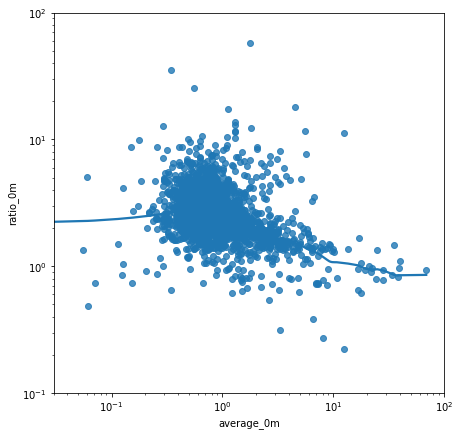

In [32]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
plt.xlim(0.03,100)
plt.ylim(0.1,100)
sns.regplot(x=df_AC['average_0m'], y=df_AC['ratio_0m'], data=df_AC, lowess=True, color=None, marker='o')


1.66348035008
1.80004845092


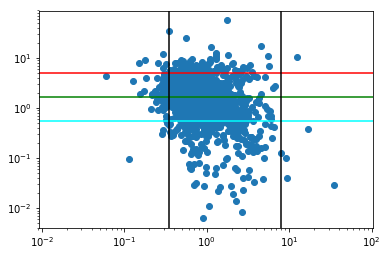

In [52]:
from statsmodels.nonparametric.smoothers_lowess import lowess

pd.set_option('use_inf_as_na', True)
df_AC.dropna(inplace=True)

lowess = lowess(df_AC['average_0m'], df_AC['ratio_0m'], return_sorted=False)

lowess_corrected = df_AC['ratio_0m']-lowess

test_median=lowess_corrected.median(axis=0)
print test_median
test_mean=lowess_corrected.mean(axis=0)
print test_mean

plt.plot(df_AC['average_0m'],lowess_corrected,linestyle='none',marker='o')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(0.03,100)
#plt.ylim(0.005,500)
plt.axhline(0.33*test_median, color='cyan')
plt.axhline(test_median, color='green')
plt.axhline(3*test_median, color='red')

plt.axvline(0.35, color='black')
plt.axvline(8, color='black')


